## Load dataset

In [1]:
import os
import pandas as pd

#PATH = os.getenv('PATH', 0)

#os.environ["PATH"] = "E:/UF/ifwaste/data/"


food_categories = [
    'Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 'Dry Foods & Baked Goods',
    'Snacks, Condiments, Liquids, Oils, Grease, & Other', 'Store-Prepared Items'
]

lookup_df = pd.DataFrame({
    'Type': ['Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 'Dry Foods & Baked Goods', 
             'Snacks, Condiments, Liquids, Oils, Grease, & Other', 'Store-Prepared Items'],
    'Servings_to_Kg': [0.09, 0.109, 0.116, 0.065, 0.095, 0.095],
    "Color": ["#41afaa", "#00a0e1", "#466eb4", "#e6a532", "#d7642c","#af4b91"]
})
# Define a color palette for the different statuses
status_colors = {
            "Inedible Parts": "#FF5F1F",
            "Plate Waste": "#008F8C",
            "Spoiled Food": "#FFD700",
            # Add more status colors if needed
        }
colors = ["#26547C", "#e6aa20", "#c71e47", "#466eb4"]

# Define the mapping of main_folder names to legend labels
legend_labels = {
        '2a_0k': '0 children',
        '2a_2k': '2 children',
        '2a_4k': '4 children',
        '2a_6k': '6 children'
        # Add more mappings as needed
    }
    
color_mapping = dict(zip(lookup_df['Type'], lookup_df['Color']))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

In [3]:
PATH = r"/blue/carpena/haasehelen/ifwaste/output/gsua_test/"

In [4]:

def load_data() -> dict[str, dd.DataFrame]:
    # Dictionary to store DataFrames by main folder and CSV file type
    dataframes = {}
    print(PATH)

    # List of the main folders to process
    main_folders = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]
    df_dict = dict()

    # Iterate over each main folder
    for main_folder in main_folders:
        folder_path = os.path.join(PATH, main_folder) # type: ignore
        # Iterate over each run folder inside the main folder
        for run_folder in os.listdir(folder_path):
            run_path = os.path.join(folder_path, run_folder)
            if os.path.isdir(run_path):
                run_id = run_folder.split('_')[-1]  # Extract the run ID from the folder name
                # Read each CSV type and append the DataFrame to the respective list
                file_names = [f for f in os.listdir(os.path.join(folder_path, run_folder)) if os.path.isfile(os.path.join(folder_path,run_folder, f))]
                for file in file_names:
                    file_path = os.path.normpath(os.path.join(run_path, file))
                    if os.path.exists(file_path):
                        # Read the CSV file into a Dask DataFrame
                        df = dd.read_csv(file_path)
                        df["run_id"] =  int(run_id)
                        df_dict.setdefault(file[:-4], []).append(df)
        # Combine all runs into a single DataFrame for each CSV type
        combined_dfs = {csv_type: dd.concat(df_list, axis=0, ignore_index=True) 
                        for csv_type, df_list in df_dict.items()}
        
        # Store the combined DataFrames in the main dictionary under the main folder key
        dataframes[main_folder] = combined_dfs

    return dataframes

In [5]:
data = load_data()

/blue/carpena/haasehelen/ifwaste/output/gsua_test/


In [ ]:
data.keys()

dict_keys(['run_0'])

In [10]:
data["run_0"]

{}

In [9]:
data["run_0"]["log_wasted"].head()

KeyError: 'log_wasted'

In [12]:

main_folders = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]
main_folders = sorted(main_folders)
main_folders

['2a_0k', '2a_2k', '2a_4k', '2a_6k']

In [11]:
n_households = len(data[main_folders[0]]["config"]["House"].unique())
n_households


NameError: name 'main_folders' is not defined

In [18]:
#TEMP 
DAYS = 100

## General Statistics: Per capita waste, consumption, groceries per day


### Biomass Check: Sanity Checks 
Cell checks whether the Biomass is balanced, aggregated over household size and all days: bought - (eaten + wasted + remaining) = 0 


In [ ]:
for file in main_folders: 
    dataset = data[file]
    bought = dataset["bought"]["Kg"].sum().compute()
    eaten = dataset["eaten"]["Kg"].sum().compute()
    wasted = dataset["wasted"]["Kg"].sum().compute()
    max_day = dataset["still_have"]["Day"].max().compute()
    left = dataset["still_have"][dataset["still_have"]["Day"] == max_day]["Kg"].sum().compute()
    
    print("group: ", file)
    print("bought total Kg: ", bought)
    print("eaten total Kg: ", eaten)
    print("wasted total Kg: ", wasted)    
    print("left last day in Kg: ", left)
    
    diff = bought - (eaten + wasted + left)

    print("bought - consumed: ", diff)

### 'calculate_average_daily' calculates the average daily (category=eaten,wasted...) aggregated by household size

In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np

def preprocess_data(dask_df, per_capita):
    # Extract Dask DataFrames
    config_df = dask_df["config"].compute()
    wasted = dask_df["wasted"]
    
    # Merge data with configuration to get House information
    merged_df = dd.merge(wasted, config_df[['House', 'Adults', 'Children']], on='House', how='inner')
    
    # Calculate the total number of people
    total_people = 1
    if per_capita:
        total_people = config_df['Adults'][0].values[0] + config_df['Children'][0].values[0]
    # Group by day and House, then sum waste and normalize if per capita
    df_grouped = merged_df.groupby(by=["Day Wasted", 'House'])['Servings'].sum().compute()
    df_grouped = df_grouped / total_people

    # Convert to a DataFrame and reset index
    df_grouped = df_grouped.reset_index()

    # Create a DataFrame with all days and houses
    all_days = range(df_grouped["Day Wasted"].min(), df_grouped["Day Wasted"].max() + 1)
    all_houses = merged_df['House'].unique().compute()
    all_combinations = pd.MultiIndex.from_product([all_days, all_houses], names=["Day Wasted", 'House'])
    
    # Reindex to include all days and houses, filling missing values with 0
    df_complete = df_grouped.set_index(["Day Wasted", 'House']).reindex(all_combinations, fill_value=0).reset_index()
    print(df_complete.head())
    print(df_complete["Servings"].std())
    print(df_complete["Servings"].mean())
    # Convert back to a Dask DataFrame
    df_complete = dd.from_pandas(df_complete, npartitions=1)
    

    return df_complete


In [ ]:
prep_0k = preprocess_data(data["2a_0k"],True)
prep_0k.head()

In [ ]:
prep_0k.columns

In [ ]:
def calculate_daily_stats(df_complete):
    daily_stats = df_complete.groupby('Day Wasted')['Servings'].agg(['mean', 'std']).reset_index()
    return daily_stats

stats_0k  = calculate_daily_stats(prep_0k)

In [ ]:
import numpy as np
import scipy.stats as stats

def calculate_ci(data, n, confidence=0.95):
    
    # Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
    
    # Standard Error of the Mean (SEM)
    sem = data["std"] / np.sqrt(n)
    
    # Confidence interval range
    data["ci_lower"] = data["mean"] - z_score * sem
    data["ci_upper"] = data["mean"] + z_score * sem
    
    return data
n = 5000

# Calculate confidence intervals

ci_df = calculate_ci(stats_0k,  n)



In [ ]:
ci_df.head()

In [ ]:
from scipy import stats

In [ ]:
def calculate_average_by_day(data, category: str, per_capita: bool):
    eaten_statistics = {folder: {'mean': [0] * DAYS,
                                 'ci_lower': [0] * DAYS,
                                 'ci_upper': [0] * DAYS,
                                 "std": 0} for folder in main_folders}  # std is overall, not per day
    for main_folder, dfs in data.items():
        config_df = dfs['config'].compute()
        df = dfs[category].compute()

        # Ensure that all houses and all days are present, even if no waste was recorded
        all_days = pd.DataFrame({'Day Wasted': range(DAYS)})
        all_houses = config_df['House'].unique()
        
        # Create a DataFrame with all combinations of houses and days
        house_day_combinations = pd.MultiIndex.from_product([all_days['Day Wasted'], all_houses], names=['Day Wasted', 'House'])
        full_df = pd.DataFrame(index=house_day_combinations).reset_index()

        # Merge the full day/house combinations with the actual data, filling missing Kg values with 0
        merged_df = pd.merge(full_df, df, on=['Day Wasted', 'House'], how='left').fillna(0)

        # Merge with the configuration DataFrame to get the number of people per house
        merged_df = pd.merge(merged_df, config_df[['House', 'Adults', 'Children']], on='House', how='inner')
        num_houses = len(merged_df['House'].unique())

        daily_totals = merged_df.groupby('Day Wasted')['Servings'].sum()  # Total 'Kg' per day

        total_people = 0
        if per_capita:
            total_people = config_df['Adults'].sum() + config_df['Children'].sum()
        else:
            total_people = num_houses

        # Loop to calculate per-day averages and confidence intervals
        for day in range(DAYS):
            # Calculate average per day
            avg = daily_totals[day] / total_people 
            eaten_statistics[main_folder]['mean'][day] = avg

            # Sum values for today per "House"
            daily_values = merged_df[merged_df['Day Wasted'] == day].groupby('House')['Servings'].sum()
            # Calculate standard deviation (std)
            std = np.std(daily_values)
            eaten_statistics[main_folder]['std'] = std
            n = len(daily_values)  # Number of houses that reported 'Kg' for the day
            if n > 1 and avg is not None:
                # Calculate SEM for the day
                sem = stats.sem(daily_values)  # Standard error of the mean
                ci = sem * stats.t.ppf(0.975, n - 1)  # 95% CI
                eaten_statistics[main_folder]['ci_lower'][day] = avg - ci
                eaten_statistics[main_folder]['ci_upper'][day] = avg + ci
            else:
                print(f"N is too small for calculating CI on day {day}")
    return eaten_statistics


In [ ]:
waste_per_day_capita = calculate_average_by_day(data=data, category="wasted", per_capita=True)

In [ ]:
waste_per_day_capita = calculate_average_by_day(data, "wasted", True)

In [ ]:
waste_per_day = calculate_average_by_day(data, "wasted", False)

In [ ]:
waste_per_day["2a_0k"]["mean"][0:5]

In [ ]:
waste_per_day["2a_0k"]["ci_lower"][0:5]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_average_with_ci(eaten_statistics):
    # Set the figure size and DPI for higher resolution (300 DPI is standard for papers)
    plt.figure(figsize=(10, 6), dpi=300)
    
    for i, (main_folder, stats) in enumerate(eaten_statistics.items()):
        label = legend_labels.get(main_folder, main_folder)
    
        days = range(len(stats['mean']))  # X-axis is the number of days
        mean_values = np.array(stats['mean'])
        ci_lower = np.array(stats['ci_lower'])
        ci_upper = np.array(stats['ci_upper'])

        # Only plot if there is valid data
        if mean_values[0] is not None:
            plt.plot(days, mean_values, '-o', label=label, color=colors[i % len(colors)])

            # Fill between the confidence intervals
            plt.fill_between(days, ci_lower, ci_upper, alpha=0.3, color=colors[i % len(colors)])

    # Set axis labels
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Daily food waste per Person (in kg)', fontsize=12)
    
    # Customize legend
    plt.legend(fontsize=10)
    
    # Add grid for better readability
    plt.grid(True)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [ ]:
plot_average_with_ci(waste_per_day_capita)

In [ ]:
plot_average_with_ci(waste_per_day)

### Table showing average and std of waste for families of different household sizes

In [ ]:
def generate_avg_std_table(dataset,per_capita: bool):
    for folder in main_folders:
        config_df = data[folder]['config'].compute()
        total_people = 1
        if per_capita:
            total_people = config_df['Adults'][0].values[0] + config_df['Children'][0].values[0]
        
        avg = sum(dataset[folder]["mean"]) / (len(dataset[folder]["mean"]))
        
        df = data[folder]["wasted"].compute()
        df = pd.merge(df, config_df[['House', 'Adults', 'Children']], on='House', how='inner')

        # Group by Day and House, then calculate daily total per house
        df_grouped = df.groupby(by=['Day Wasted', 'House'])['Servings'].sum()  
        df_grouped = df_grouped / total_people
        # Calculate the standard deviation across the entire dataset
        std = df_grouped.std()

        # Print results
        print(f"Group: {folder}: {avg:.2f} avg, {std:.5f} std")


In [ ]:
generate_avg_std_table(waste_per_day_capita,True)

In [ ]:
generate_avg_std_table(waste_per_day,False)

## Waste averages with CI by LOC and family size

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

def calculate_average_LOC(data, bins: list[float], category: str, per_capita: bool):

    interval_labels = pd.IntervalIndex.from_breaks(bins, closed='right')
    eaten_statistics = {main_folder: {'mean': [None] * len(interval_labels),
                                      'ci_lower': [None] * len(interval_labels),
                                      'ci_upper': [None] * len(interval_labels)}
                        for main_folder in data.keys()}

    for main_folder, dfs in data.items():
        config_df = dfs['config'].compute()
        config_df['concern_interval'] = pd.cut(config_df['lvl_of_concern'], bins=interval_labels)
        df = dfs[category][dfs[category]['day'] >= 14].compute()
        merged_df = pd.merge(df, config_df[['household', 'concern_interval', 'adults', 'children']],
                             on='household', how='inner')

        for idx, interval in enumerate(interval_labels):
            group = config_df[config_df['concern_interval'] == interval]
            household_ids = group['household'].tolist()
            interval_df = merged_df[merged_df['household'].isin(household_ids)]
            
            if not group.empty and not interval_df.empty:
                if per_capita: 
                    total_people = group['adults'].sum() + group['children'].sum()
                else: 
                    total_people = len(group)
                    
                total = interval_df.groupby(['day', 'household'])['servings'].sum()
                n = len(total)
                print(household_ids)
                print(n)
                
                total = total.sum()
                
                avg = total / (total_people * (DAYS - 14))
                eaten_statistics[main_folder]['mean'][idx] = avg
                
                # Calculate confidence interval
                if n > 1:  # To avoid division by zero or invalid CI calculation
                    sem = stats.sem(interval_df['servings'])
                    ci = sem * stats.t.ppf(0.975, n - 1)  # 95% CI
                    eaten_statistics[main_folder]['ci_lower'][idx] = avg - ci
                    eaten_statistics[main_folder]['ci_upper'][idx] = avg + ci
                else:
                    eaten_statistics[main_folder]['ci_lower'][idx] = np.nan
                    eaten_statistics[main_folder]['ci_upper'][idx] = np.nan
    
    return eaten_statistics


In [ ]:
import matplotlib.pyplot as plt

def plot_average_LOC_with_ci(eaten_statistics, interval_labels):
    plt.figure(figsize=(10, 6))
    
    for main_folder in main_folders:
        if main_folder in eaten_statistics:
            stats = eaten_statistics[main_folder]
            # Get the legend label based on the mapping
            label = legend_labels.get(main_folder, main_folder)
            
            # Plot average values with error bars for the confidence interval
            plt.errorbar(interval_labels.mid, stats['mean'], 
                         yerr=[np.array(stats['mean']) - np.array(stats['ci_lower']),
                               np.array(stats['ci_upper']) - np.array(stats['mean'])],
                         fmt='-o', capsize=5, label=label)

    plt.xlabel('Level of Concern (in %)')
    plt.ylabel('Daily Food Waste (in Kg)')
    plt.legend()
    plt.xticks(ticks=interval_labels.mid, labels=[f"{int(i.left*100)}-{int(i.right*100)}%" for i in interval_labels])
    plt.grid(True)
    plt.show()


In [ ]:
def calculate_average_daily(data,bins:list[float],category:str, per_capita:bool):
    # Define intervals in 0.1 steps
    interval_labels = pd.IntervalIndex.from_breaks(bins, closed='right')
    eaten_statistics = {main_folder: [None] * len(interval_labels) for main_folder in data.keys()}
    sim_days = data[list(data.keys())[0]][category]["day"].max().compute() + 1

    for main_folder, dfs in data.items():
        config_df = dfs['config'].compute()
        config_df['concern_interval'] = pd.cut(config_df['lvl_of_concern'], bins=interval_labels)
        #df = dfs[category][dfs[category]['day'] >= 14].compute()
        merged_df = pd.merge(dd.DataFrame(dfs), config_df[['household', 'concern_interval', 'adults', 'children']],
                             on='household', how='inner')

        for idx, interval in enumerate(interval_labels):
            group = config_df[config_df['concern_interval'] == interval]
            household_ids = group['household'].tolist()
            interval_df = merged_df[merged_df['household'].isin(household_ids)]
            
            if not group.empty and not interval_df.empty:
                if per_capita: 
                    total_people = group['adults'].sum() + group['children'].sum()
                else: 
                    total_people = len(group)
                    
                total = interval_df['servings'].sum()
                avg = total / (total_people * (sim_days - 14))
                eaten_statistics[main_folder][idx] = avg
    
    return eaten_statistics

Calculating all the average values per person and per household and per loc within 
interval ranges. 


In [ ]:

# Calculate the average daily amount eaten per person grouped by LevelOfConcern intervals
bins = [i / 10 for i in range(11)] #10% increments
# Define intervals for x-axis labels
intervals = ['0%-10%', '10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%', '70%-80%', '80%-90%', '90%-100%']

average_eaten_by_concern = calculate_average_daily(data,bins=bins,category="eaten", per_capita=True)
average_wasted_by_concern = calculate_average_daily(data,bins=bins,category="wasted", per_capita=True)
average_bought_by_concern = calculate_average_daily(data,bins=bins,category="bought", per_capita=True)

average_eaten_by_concern_hh = calculate_average_daily(data,bins=bins,category="eaten", per_capita=False)
average_wasted_by_concern_hh = calculate_average_daily(data,bins=bins,category="wasted", per_capita=False)
average_bought_by_concern_hh = calculate_average_daily(data,bins=bins,category="bought", per_capita=False)


In [ ]:
# Calculate percentage difference
percentage_difference = {}
for key in average_eaten_by_concern_hh:
    # Calculate percentage for each value
    percentage_difference[key] = [
        (1 - (v1 / v2))*100 if v2 != 0 else None
        for v1, v2 in zip(average_eaten_by_concern_hh[key], average_bought_by_concern_hh[key])
    ]
percentage_difference

In [ ]:

# Create a figure and axis
plt.figure(figsize=(12, 8))

# Plot each category
for key, values in percentage_difference.items():
    plt.plot(values, label=key, marker='o')

# Add titles and labels
plt.title('Percentage of wasted food in relation to bought food grouped by household size and LOC')
plt.xlabel('Level of Concern (LOC)')
plt.xticks(ticks=range(len(intervals)), labels=intervals)
plt.ylabel('Percentage')
plt.legend(title='Categories')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_average(average: dict, category_title: str, intervals: list[str], is_household: bool = False):
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot each main_folder data as a separate line
    for main_folder, values in average.items():
        plt.plot(intervals, values, marker='o', label=main_folder)

    # Customize the plot
    group = "Household" if is_household else "Person"
    
    # Set axis labels
    plt.xlabel('Level of Concern Interval (in %)')
    plt.ylabel(f'Average Daily {category_title} Amount (in Kg)')
    
    # Add grid
    plt.grid(True)
    
    # Rotate the x-axis tick labels
    plt.xticks(rotation=45)
    
    # Add the legend anchored to the top right corner
    plt.legend(title='Adults:Kids', loc='upper right', bbox_to_anchor=(1.05, 1), fontsize=10)

    # Adjust layout to prevent clipping of elements
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [ ]:
plot_average(average_bought_by_concern, "Bought", intervals)
plot_average(average_wasted_by_concern, "Wasted", intervals)
plot_average(average_eaten_by_concern, "Eaten", intervals)
plot_average(average_bought_by_concern_hh, "Bought", intervals, True)
plot_average(average_eaten_by_concern_hh, "Eaten", intervals, True)
plot_average(average_wasted_by_concern_hh, "Wasted", intervals, True)

### Deviation/Mean/Boxplots stats 

In [ ]:
import pandas as pd
import dask.dataframe as dd

def get_average_by_loc(data, bins: list[float], category: str, per_capita: bool):
    # Define intervals
    interval_labels = pd.IntervalIndex.from_breaks(bins, closed='right')
    individual_data = {main_folder: [] for main_folder in data.keys()}

    for main_folder, dfs in data.items():
        result = pd.DataFrame()
        
        config_df = dfs['config'].compute()
        config_df['ConcernInterval'] = pd.cut(config_df['LvlOfConcern'], bins=interval_labels)
        category_df = dfs[category][dfs[category]['Day'] >= 14].compute()
        merged_df = pd.merge(category_df, config_df[['House', 'ConcernInterval', 'Adults', 'Children']],
                             on='House', how='inner')

        for interval in interval_labels:
            group = config_df[config_df['ConcernInterval'] == interval]
            
            household_ids = group['House'].tolist()
            interval_data_df = merged_df[merged_df['House'].isin(household_ids)]
            
            for id in household_ids:
                if per_capita:
                    total_people = group[group['House'] == id]['Adults'].sum() + group[group['House'] == id]['Children'].sum()
                else:
                    total_people = len(group)
                
                # Calculate individual samples
                total_eaten = interval_data_df[interval_data_df['House'] == id]['Kg'].sum()
                days = category_df['Day'].max() + 1 - 14
                average = total_eaten / (total_people * days) if days > 0 else 0

                new_row = pd.DataFrame({
                    "LvlOfConcern": [interval],
                    "House": [id], 
                    "Average": [average]
                })

                result = pd.concat([result, new_row], ignore_index=True)
                
        result = dd.from_pandas(result, npartitions=1)
        individual_data[main_folder] = result
        
    return individual_data


In [ ]:
sorted_wasted = get_average_by_loc(data=data, bins=bins, category="wasted", per_capita=True)

for violin plot use sorted data. Sorted data includes all samples of averages.

In [ ]:

def plot_violin_plot(data:dict, hhsize:str, bins:list[float]):
    
    df = data[hhsize].compute()
    # Convert 'LvlOfConcern' to string if necessary
    df['LvlOfConcern'] = df['LvlOfConcern'].astype(str)

    # Calculate mean, std, count, CV, and IQR per LvlOfConcern
    stats_per_concern = df.groupby('LvlOfConcern')['Average'].agg(['mean', 'std', 'count']).reset_index()
    stats_per_concern['CV'] = stats_per_concern['std'] / stats_per_concern['mean']
    stats_per_concern['IQR'] = df.groupby('LvlOfConcern')['Average'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25)).values

    # Rename columns for clarity
    stats_per_concern.columns = ['LvlOfConcern', 'AvgMean', 'StdDev', 'Count', 'CV', 'IQR']

    # Plotting IQR and density distribution using a violin plot
    plt.figure(figsize=(14, 8))
    sns.violinplot(x='LvlOfConcern', y='Average', data=df, inner=None, color='lightgray')
    sns.boxplot(x='LvlOfConcern', y='Average', data=df, width=0.2)
    plt.xlabel('Level of Concern')
    plt.ylabel('Average')
    plt.title('Data distribution by LOC')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_violin_plot(sorted_wasted, "2a_0k", bins )
plot_violin_plot(sorted_wasted, "2a_2k", bins )
plot_violin_plot(sorted_wasted, "2a_4k", bins )
plot_violin_plot(sorted_wasted, "2a_6k", bins )

In [ ]:


# Assuming sorted_data["2a_0k"] is a Dask DataFrame
df = sorted_wasted["2a_2k"].compute()  # Convert Dask DataFrame to Pandas DataFrame

# Convert 'LvlOfConcern' to string if necessary
df['LvlOfConcern'] = df['LvlOfConcern'].astype(str)

# Calculate mean, std, count, CV, and IQR per LvlOfConcern
stats_per_concern = df.groupby('LvlOfConcern')['Average'].agg(['mean', 'std', 'count']).reset_index()
stats_per_concern['CV'] = stats_per_concern['std'] / stats_per_concern['mean']
stats_per_concern['IQR'] = df.groupby('LvlOfConcern')['Average'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25)).values

# Rename columns for clarity
stats_per_concern.columns = ['LvlOfConcern', 'AvgMean', 'StdDev', 'Count', 'CV', 'IQR']

# Plotting IQR and density distribution using a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='LvlOfConcern', y='Average', data=df, inner=None, color='lightgray')
sns.boxplot(x='LvlOfConcern', y='Average', data=df, width=0.2)
plt.xlabel('Level of Concern')
plt.ylabel('Average')
plt.title('Data distribution by LOC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
stats_per_concern.head(10)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

result = sorted_wasted["2a_0k"]

result['LvlOfConcern'] = result['LvlOfConcern'].astype(str)
result = result.drop(columns=["House"])


result = result.compute()
plt.figure(figsize=(12, 6))
result.boxplot(column='Average', by='LvlOfConcern', grid=False, showfliers=True)
plt.title('Boxplot of Average by Level of Concern')
plt.suptitle('')  # Suppress the default title to clean up the plot
plt.xlabel('Level of Concern')
plt.ylabel('Average')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Serving intake and eating behavior

In [ ]:
dataset = data["2a_0k"]

In [ ]:
import matplotlib.pyplot as plt

eaten_df = dataset["eaten"]
config_df = dataset["config"]

household_group = eaten_df["House"].unique().compute()[0]
household_group = household_group.sample(1)[0]
hh_servings = eaten_df[eaten_df["House"] == household_group].groupby("Day")["Servings"].sum().compute()
hh_servings = hh_servings.reindex(range(DAYS), fill_value=0)
required_servings = config_df[config_df["House"] == household_group]["RequiredServings"].compute().iloc[0]

# Plotting
plt.figure(figsize=(12, 6))
days = range(0,DAYS)
plt.bar(days, hh_servings, color='skyblue', label="Servings Eaten")
plt.axhline(y=required_servings, color='r', linestyle='--', linewidth=1.5, label=f"Required Servings ({required_servings:.2f})")

plt.title(f"Servings Eaten Over 100 Days vs. Required Servings for Household {household_group}")
plt.xlabel("Day")
plt.ylabel("Servings")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import matplotlib.pyplot as plt

# Assuming 'dataset["eaten"]' and 'dataset["config"]' are Dask DataFrames
eaten_df = dataset["eaten"]
config_df = dataset["config"]

# Define level of concern ranges
concern_ranges = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]

# Create a subplot for each level of concern range
plt.figure(figsize=(20, 15))

for i, (low, high) in enumerate(concern_ranges):
    # Filter households within the current level of concern range
    filtered_households = config_df[(config_df["LvlOfConcern"] >= low) & (config_df["LvlOfConcern"] < high)]
    
    # Select a random household from this filtered group
    household_group = filtered_households["House"].sample(frac=1).compute().iloc[0]
    # Calculate servings eaten for the selected household
    hh_servings = eaten_df[eaten_df["House"] == household_group].groupby("Day")["Servings"].sum().compute()
    hh_servings = hh_servings.reindex(range(DAYS), fill_value=0)
    
    # Extract the required servings for this household
    household_config = filtered_households[filtered_households["House"] == household_group]
    required_servings = filtered_households[filtered_households["House"] == household_group]["RequiredServings"].compute().iloc[0]
    loc = household_config["LvlOfConcern"].compute().iloc[0]

    # Create subplot
    plt.subplot(3, 2, i + 1)  # Adjust the grid if needed (3 rows, 2 columns)
    
    days = range(0, 100)
    plt.bar(days, hh_servings, color='skyblue', label="Servings Eaten")
    
    # Plot the required servings line
    plt.axhline(y=required_servings, color='b', linestyle='--', linewidth=1.5, label=f"Required Servings ({required_servings:.2f})")
    
    
    plt.title(f"Servings for Household with LOC: {loc:.2f}, House: {household_group} ")
    plt.xlabel("Day")
    plt.ylabel("Servings")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'dataset' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

def plot_behavior(dataset, household: str): 
    df_daily = dataset["daily"]
    df_daily = df_daily[df_daily["House"] == household]
    
    # Select only the desired columns
    columns = ["EEF","Enough_time", "Enough_ing", "Cooked", "QuickCook", "AteLeftOvers", "QuickShop"]
    df_filtered = df_daily[columns]
    df_filtered.index = df_filtered.index.astype(int)
    df_filtered = df_filtered.compute()
    print(len(df_filtered))
    binary_cmap = ListedColormap(["#d1495b", "#7ca982"])

    plt.figure(figsize=(14, 8))  # Increased width to accommodate the new column
    ax = sns.heatmap(
        df_filtered.T,               # Transpose to get activities on y-axis
        cmap=binary_cmap,            # Use the binary colormap
        cbar=True,                   # Enable the color bar (legend)
        linewidths=0.5,
        linecolor='gray',
        vmin=0, vmax=1,              # Set limits to binary values
        cbar_kws={'ticks': [0, 1], 'label': 'Activity Occurrence'}  # Set binary ticks
    )
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0 (No)', '1 (Yes)'])
    
    row_sums = df_filtered.sum(axis=0)  # Sum each column
    for i, sum_value in enumerate(row_sums):
        ax.text(df_filtered.shape[0], i + 0.5, f'{sum_value:.0f}', ha='left', va='center', color='black')

    # Set x-axis labels
    ax.set_xticks(range(0, DAYS, 10))  # Show every 10th day on the x-axis
    ax.set_xticklabels(range(0, DAYS, 10))  # Label the x-axis with corresponding day numbers

    plt.title('Daily Activity Heatmap')
    plt.xlabel('Day')
    plt.ylabel('Activity')

    plt.show()


In [ ]:
plot_behavior(data["2a_0k"],"36_1")


### Behavior variables

In [ ]:

#E6C79C
#CDDFA0
#6FD08C
#7B9EA8
#78586F

### TODO: Comparison servings eaten vs. behavior vs. should eat
- get days where they ate too little 
- look into composition - why did they not eat enough?

## Waste over Time

### Stacked Barchart: specific Household waste types over time

In [35]:
import matplotlib.pyplot as plt


def plot_waste_type_hh(dataset, hhID, runID):
    df_wasted = dataset["wasted"]
    df_config = dataset["config"]
    # Create a subplot for each level of concern range
    plt.figure(figsize=(20, 10), dpi=300)        
    hh_wasted = df_wasted[(df_wasted['House'] == hhID) & (df_wasted["Kg"] > 0) & (df_wasted["run_id"] == runID)]
    hh_wasted = hh_wasted.groupby(["Day Wasted", "Status"])["Kg"].sum()
    hh_wasted = hh_wasted.compute().unstack(fill_value=0).reindex(columns=status_colors.keys(), fill_value=0)
    hh_wasted.plot(kind='bar', stacked=True, color=[status_colors.get(status, 'gray') for status in hh_wasted.columns], ax=plt.gca())
    
    plt.xlabel("Day Wasted", fontsize=35)
    plt.xlim(0,DAYS)
    plt.xticks(range(0, DAYS + 1, 10)) 
    plt.ylabel("Kg", fontsize=35)
    plt.legend(title="Status", fontsize=35, title_fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



In [69]:
## POSTER VERSION
import matplotlib.pyplot as plt



def plot_waste_type_hh(dataset, hhID, runID):
    df_wasted = dataset["wasted"]
    df_config = dataset["config"]
    # Create a subplot for each level of concern range
    a = df_wasted[(df_wasted['House'] == hhID) & (df_wasted["Kg"] > 0) & (df_wasted["run_id"] == runID)]
    plt.figure(figsize=(20, 15), dpi=300)        
    hh_wasted = df_wasted[(df_wasted['House'] == hhID) & (df_wasted["Kg"] > 0) & (df_wasted["run_id"] == runID)]
    hh_wasted = hh_wasted.groupby(["Day Wasted", "Status"])["Kg"].sum()
    hh_wasted = hh_wasted.compute().unstack(fill_value=0).reindex(columns=status_colors.keys(), fill_value=0)
    hh_wasted.plot(kind='bar', stacked=True, color=[status_colors.get(status, 'gray') for status in hh_wasted.columns], ax=plt.gca(), legend=False)
    
    plt.xlabel("Day", fontsize=35)
    plt.xlim(0,DAYS)
    plt.xticks(range(0, DAYS + 1, 10)) 
    plt.ylabel("Kg", fontsize=35)
    #plt.legend(title="Status", fontsize=18, title_fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=35)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



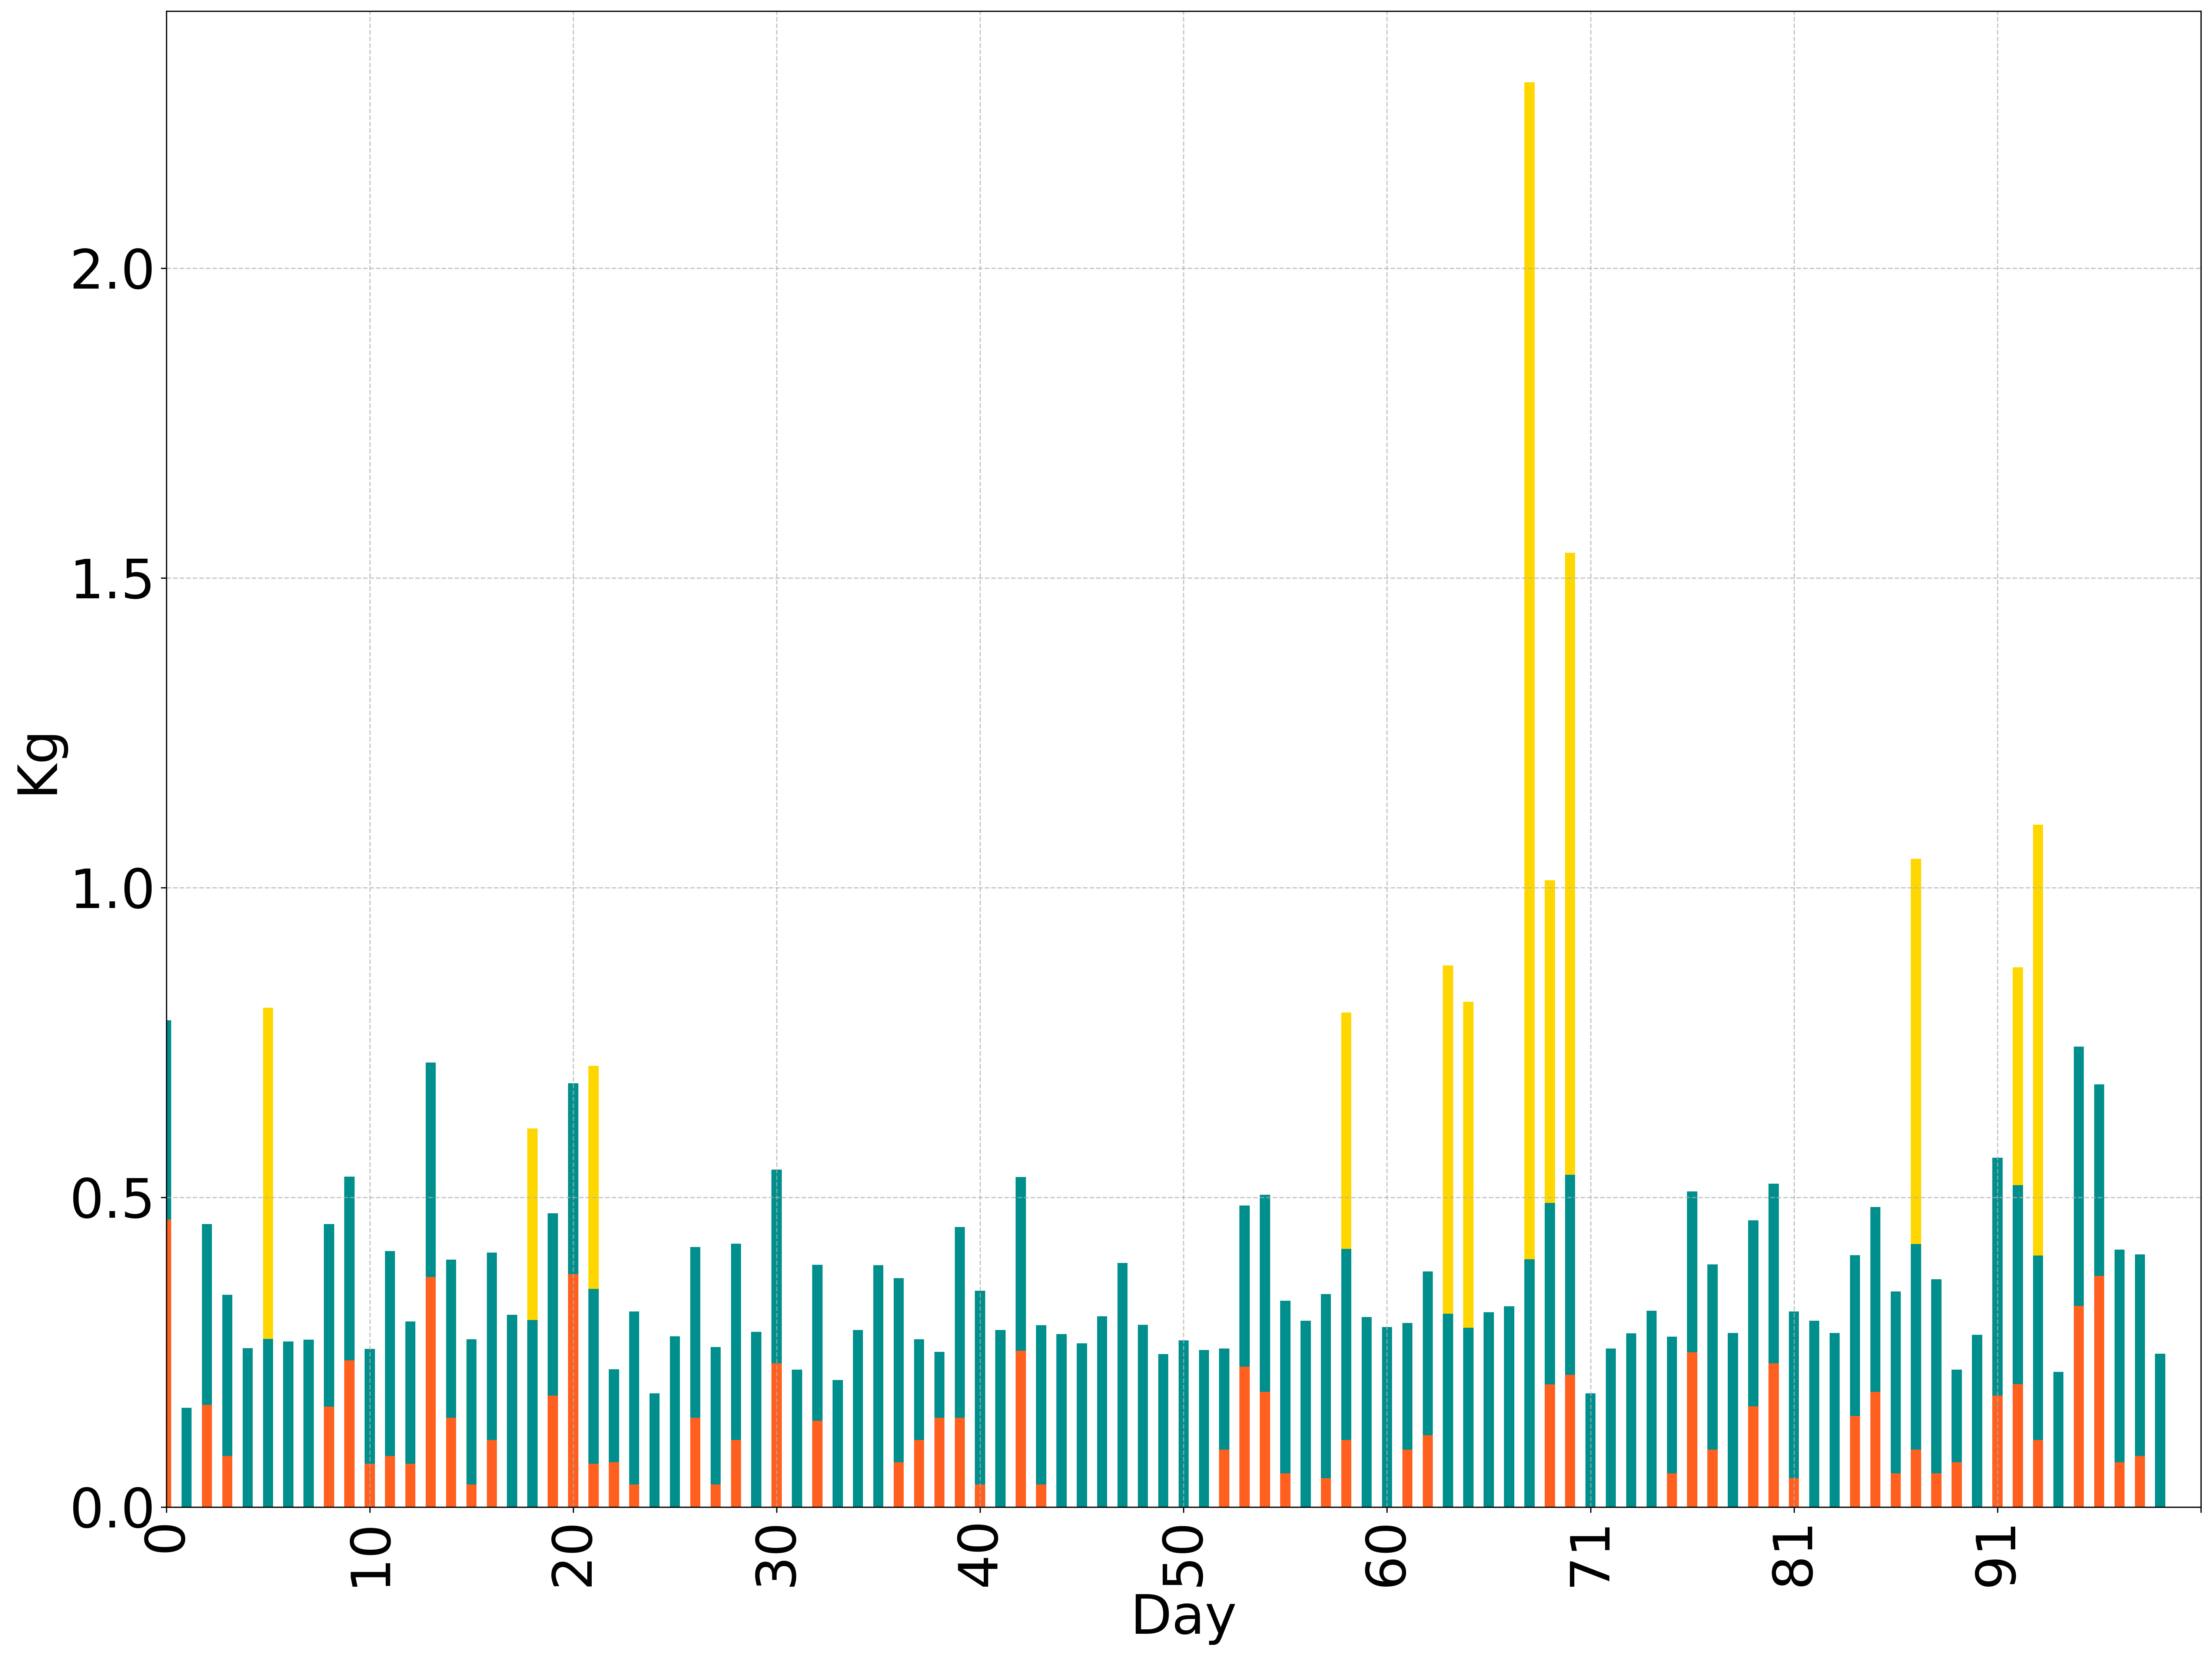

In [70]:
plot_waste_type_hh(data["2a_0k"], 0, 0)

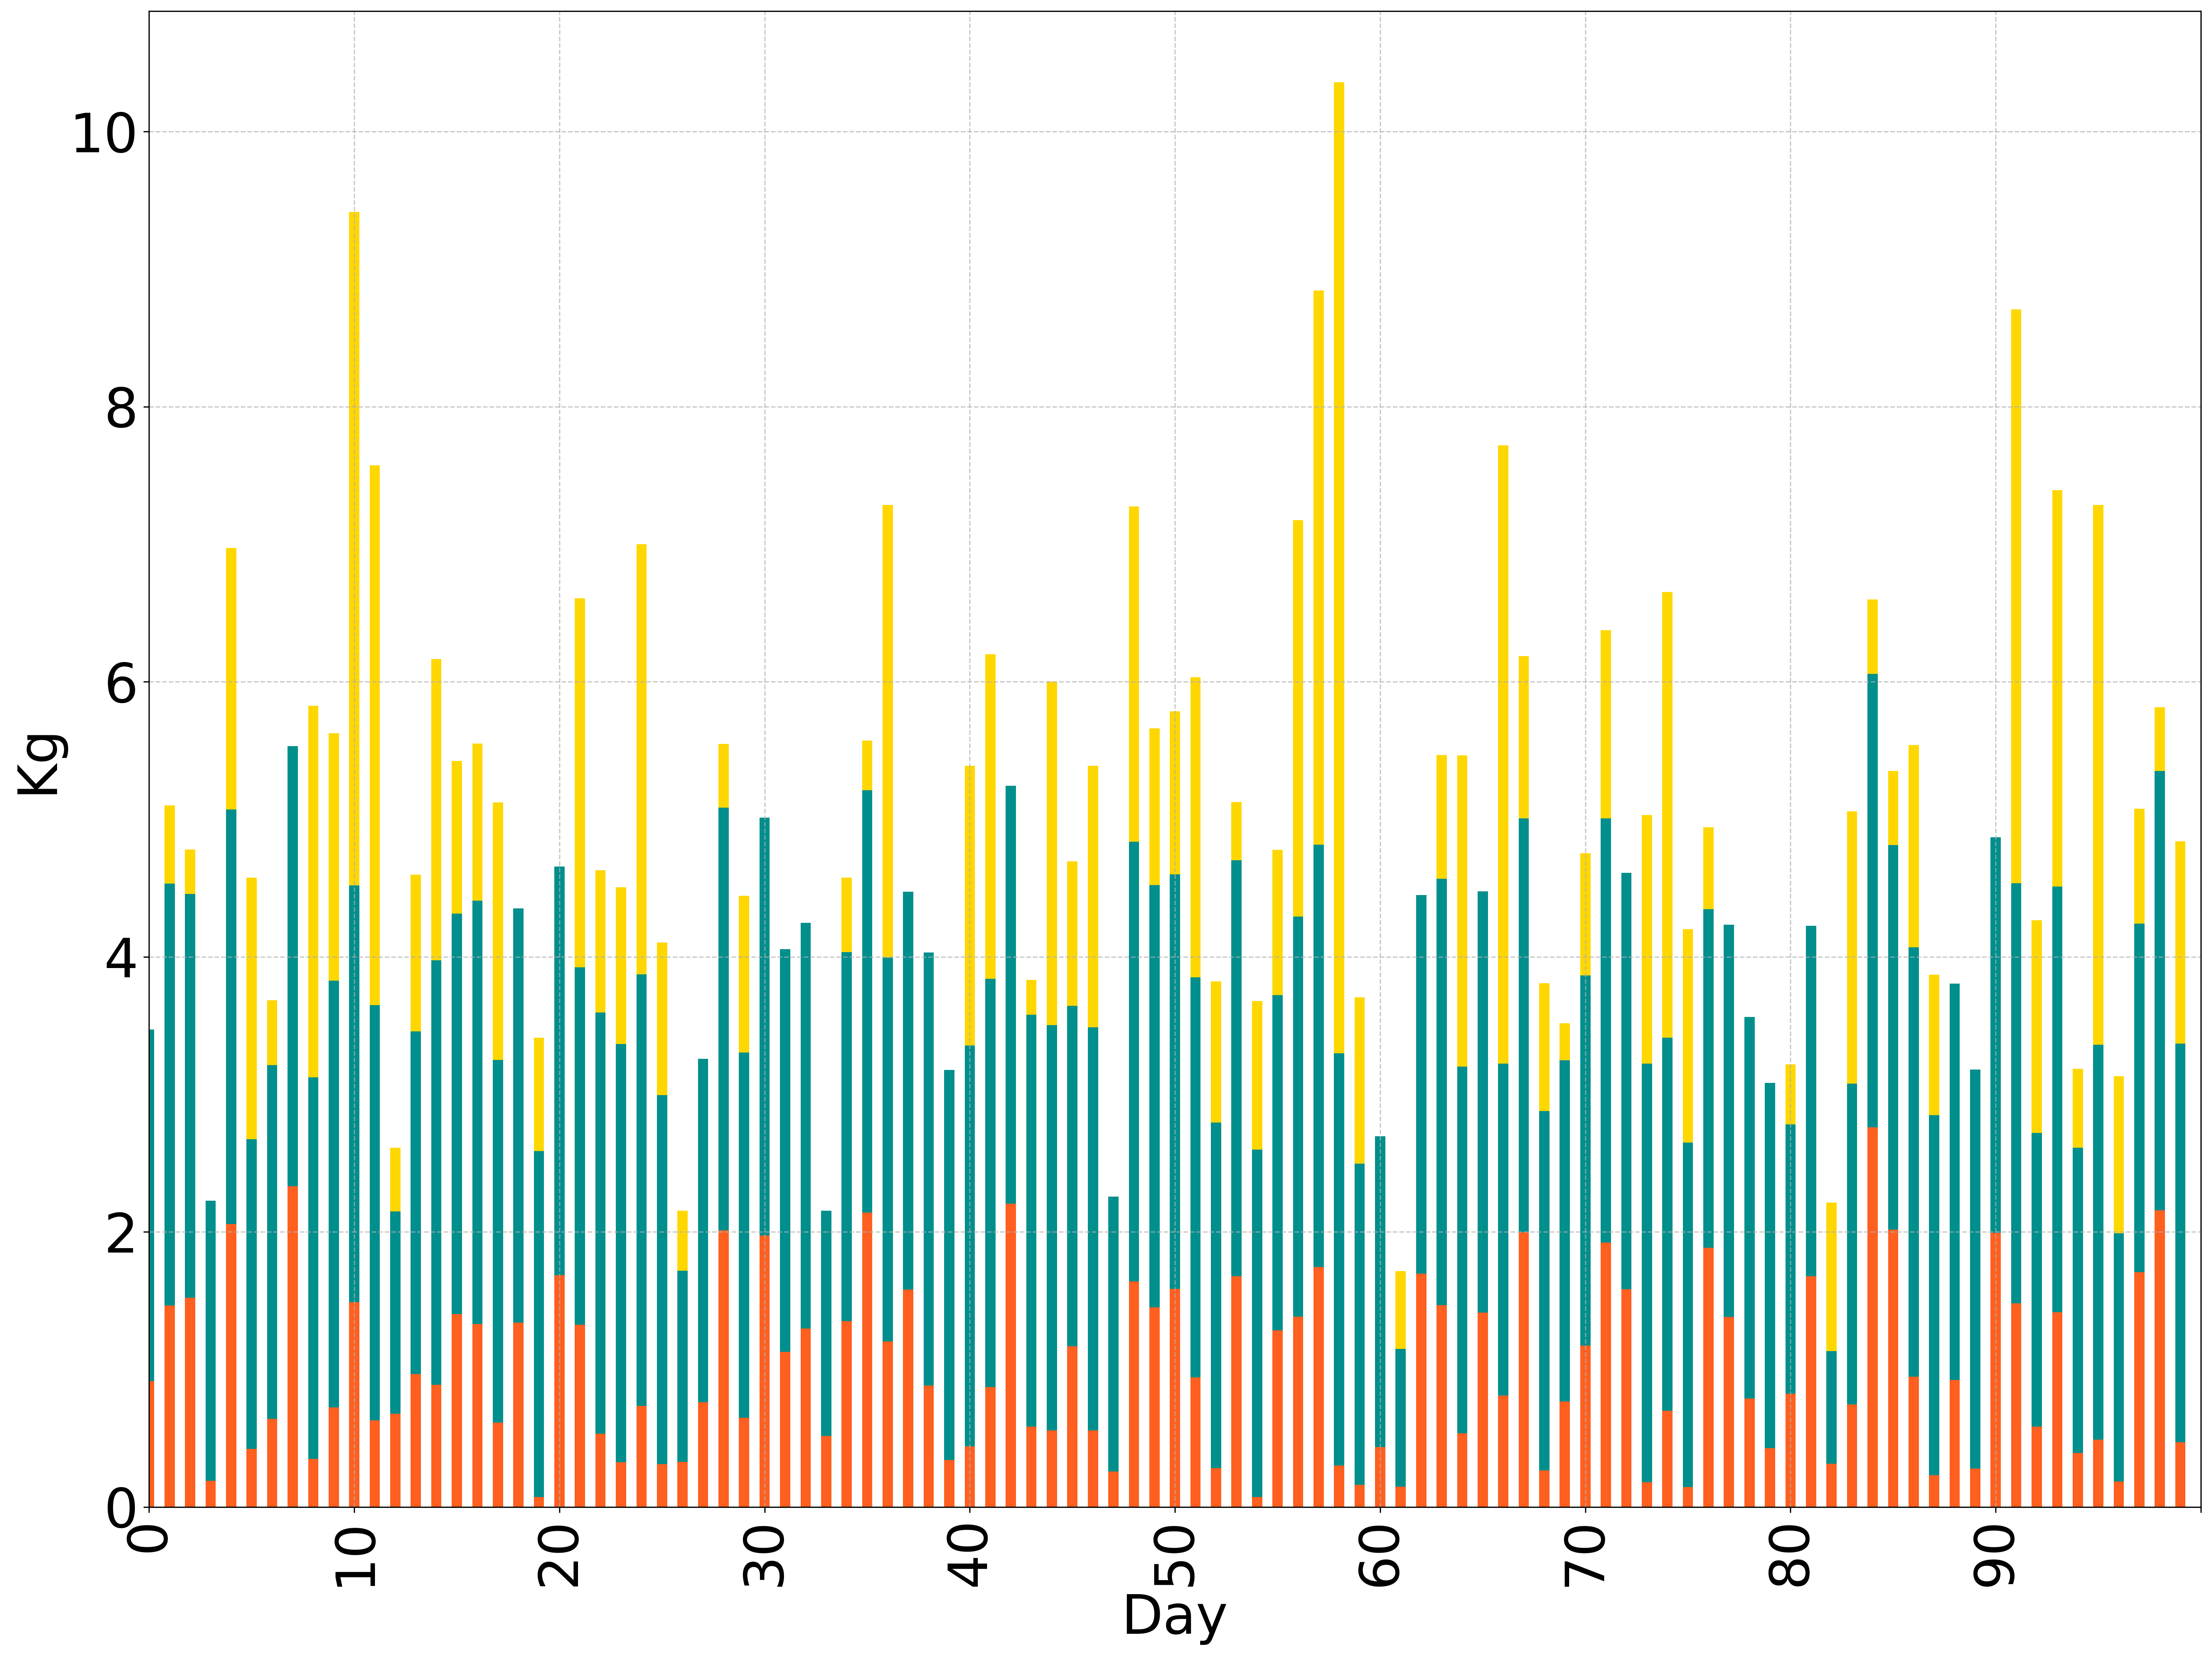

In [71]:
plot_waste_type_hh(data["2a_6k"], 0, 1)

In [ ]:
plot_waste_type_hh(data["2a_6k"], 0, 0)
plot_waste_type_hh(data["2a_6k"], 0, 1)
plot_waste_type_hh(data["2a_6k"], 0, 2)
plot_waste_type_hh(data["2a_6k"], 0, 3)

In [ ]:
#['0_46', '0_10', '0_58', '0_68']
#6 24 61 86

plot_waste_type_hh(data["2a_0k"], 0, 46)
plot_waste_type_hh(data["2a_0k"], 0, 10)
plot_waste_type_hh(data["2a_0k"], 0, 58)
plot_waste_type_hh(data["2a_0k"], 0, 68)

In [ ]:
plot_waste_type_hh(data["2a_0k"], "0_0") #6
plot_waste_type_hh(data["2a_2k"], "0_0") #34
plot_waste_type_hh(data["2a_4k"], "0_0") #61
plot_waste_type_hh(data["2a_6k"], "0_0") #84

In [ ]:
lookup_df.loc[lookup_df["Type"] == "Meat & Fish", "Color"].values[0]

### Stacked Barchart: 4 different LOC over 100 days by waste type


In [21]:
#concern_ranges = [(0.0, 0.33), (0.33, 0.66), (0.66, 1)]
concern_ranges = [(0.0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75,1)]

In [ ]:

def plot_waste_by_waste_type(dataset, concern_ranges, metric):
    df_wasted = dataset["wasted"]
    df_config = dataset["config"]
    selected_groups = []

    # Create a subplot for each level of concern range
    plt.figure(figsize=(20, 15))

    # Correctly read the integer value from the Dask DataFrame
    n_children = df_config["Children"].compute().iloc[0]  #
    for i, (low, high) in enumerate(iterable=concern_ranges):
        # Filter households within the current level of concern range
        filtered_households = df_config[(df_config["LvlOfConcern"] >= low) & (df_config["LvlOfConcern"] < high)]
        
        # Select a random household from this filtered group
        household_group = filtered_households["House"].sample(frac=1).compute().iloc[0]
        selected_groups.append(household_group)
        # Calculate servings wasted for the selected household
        hh_wasted = df_wasted[df_wasted["House"] == household_group]
    
        hh_wasted = hh_wasted.groupby(["Day", "Status"])[metric].sum()
        # Convert to Pandas DataFrame and unstack
        hh_wasted = hh_wasted.compute().unstack(fill_value=0).reindex(columns=status_colors.keys(), fill_value=0)

            
        plt.subplot(3, 2, i + 1)
        
        hh_wasted.plot(kind='bar', stacked=True, color=[status_colors.get(status, 'gray') for status in hh_wasted.columns], ax=plt.gca())
        
        loc = dataset["config"][dataset["config"]["House"] == household_group]["LvlOfConcern"].compute().iloc[0]
        plt.title(f"Food Waste for Household with LOC: {loc:.2f}, 2 Adults, {n_children} Children")
        plt.xlabel("Day")
        plt.xticks(range(0, DAYS, 10)) 
        plt.ylabel(metric)
        plt.legend(title="Status")
        plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    print(selected_groups)

In [65]:
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

def plot_waste_by_waste_type(dataset, concern_ranges, metric):
    df_wasted = dataset["wasted"]
    df_config = dataset["config"]
    selected_groups = []
    max_y_values = []
    plt.figure(figsize=(20, 15))
    n_children = df_config["Children"].compute().iloc[0]

    for low, high in concern_ranges:
        filtered_households = df_config[(df_config["LvlOfConcern"] >= low) & (df_config["LvlOfConcern"] < high)]
        household_group = filtered_households["House"].sample(frac=1).compute().iloc[0]
        selected_groups.append(household_group)
        hh_wasted = df_wasted[df_wasted["House"] == household_group]
        hh_wasted = hh_wasted.groupby(["Day Wasted", "Status"])[metric].sum()
        hh_wasted = hh_wasted.compute().unstack(fill_value=0).reindex(columns=status_colors.keys(), fill_value=0)
        max_y_values.append(hh_wasted.sum(axis=1).max())

    global_max_y = max(max_y_values)

    for i, hhID in enumerate(selected_groups):
        plt.subplot(3, 2, i + 1)        
        
        hh_wasted = df_wasted[df_wasted["House"] == hhID]
        hh_wasted = hh_wasted.groupby(["Day Wasted", "Status"])[metric].sum()
        hh_wasted = hh_wasted.compute().unstack(fill_value=0).reindex(columns=status_colors.keys(), fill_value=0)
        
        
        hh_wasted.plot(kind='bar', stacked=True, color=[status_colors.get(status, 'gray') for status in hh_wasted.columns], ax=plt.gca())
        loc = dataset["config"][dataset["config"]["House"] == hhID]["LvlOfConcern"].compute().iloc[0]
        plt.title(f"Food Waste for Household with LOC: {loc:.2f}, 2 Adults, {n_children} Children")
        plt.xlabel("Day Wasted")
        plt.xticks(range(0, DAYS, 10)) 
        plt.ylabel(metric)
        plt.legend(title="Status")
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Set the same y-axis limit for all subplots
        plt.ylim(0, global_max_y)

    plt.tight_layout()
    plt.show()
    print(selected_groups)


KeyboardInterrupt: 

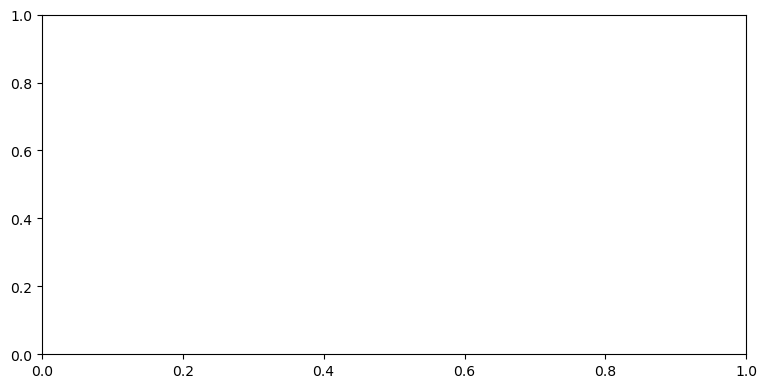

In [23]:

plot_waste_by_waste_type(data["2a_2k"],concern_ranges, "Kg")
plot_waste_by_waste_type(data["2a_2k"],concern_ranges, "Kg")
plot_waste_by_waste_type(data["2a_2k"],concern_ranges, "Kg")
plot_waste_by_waste_type(data["2a_2k"],concern_ranges, "Kg")
plot_waste_by_waste_type(data["2a_2k"],concern_ranges, "Kg")

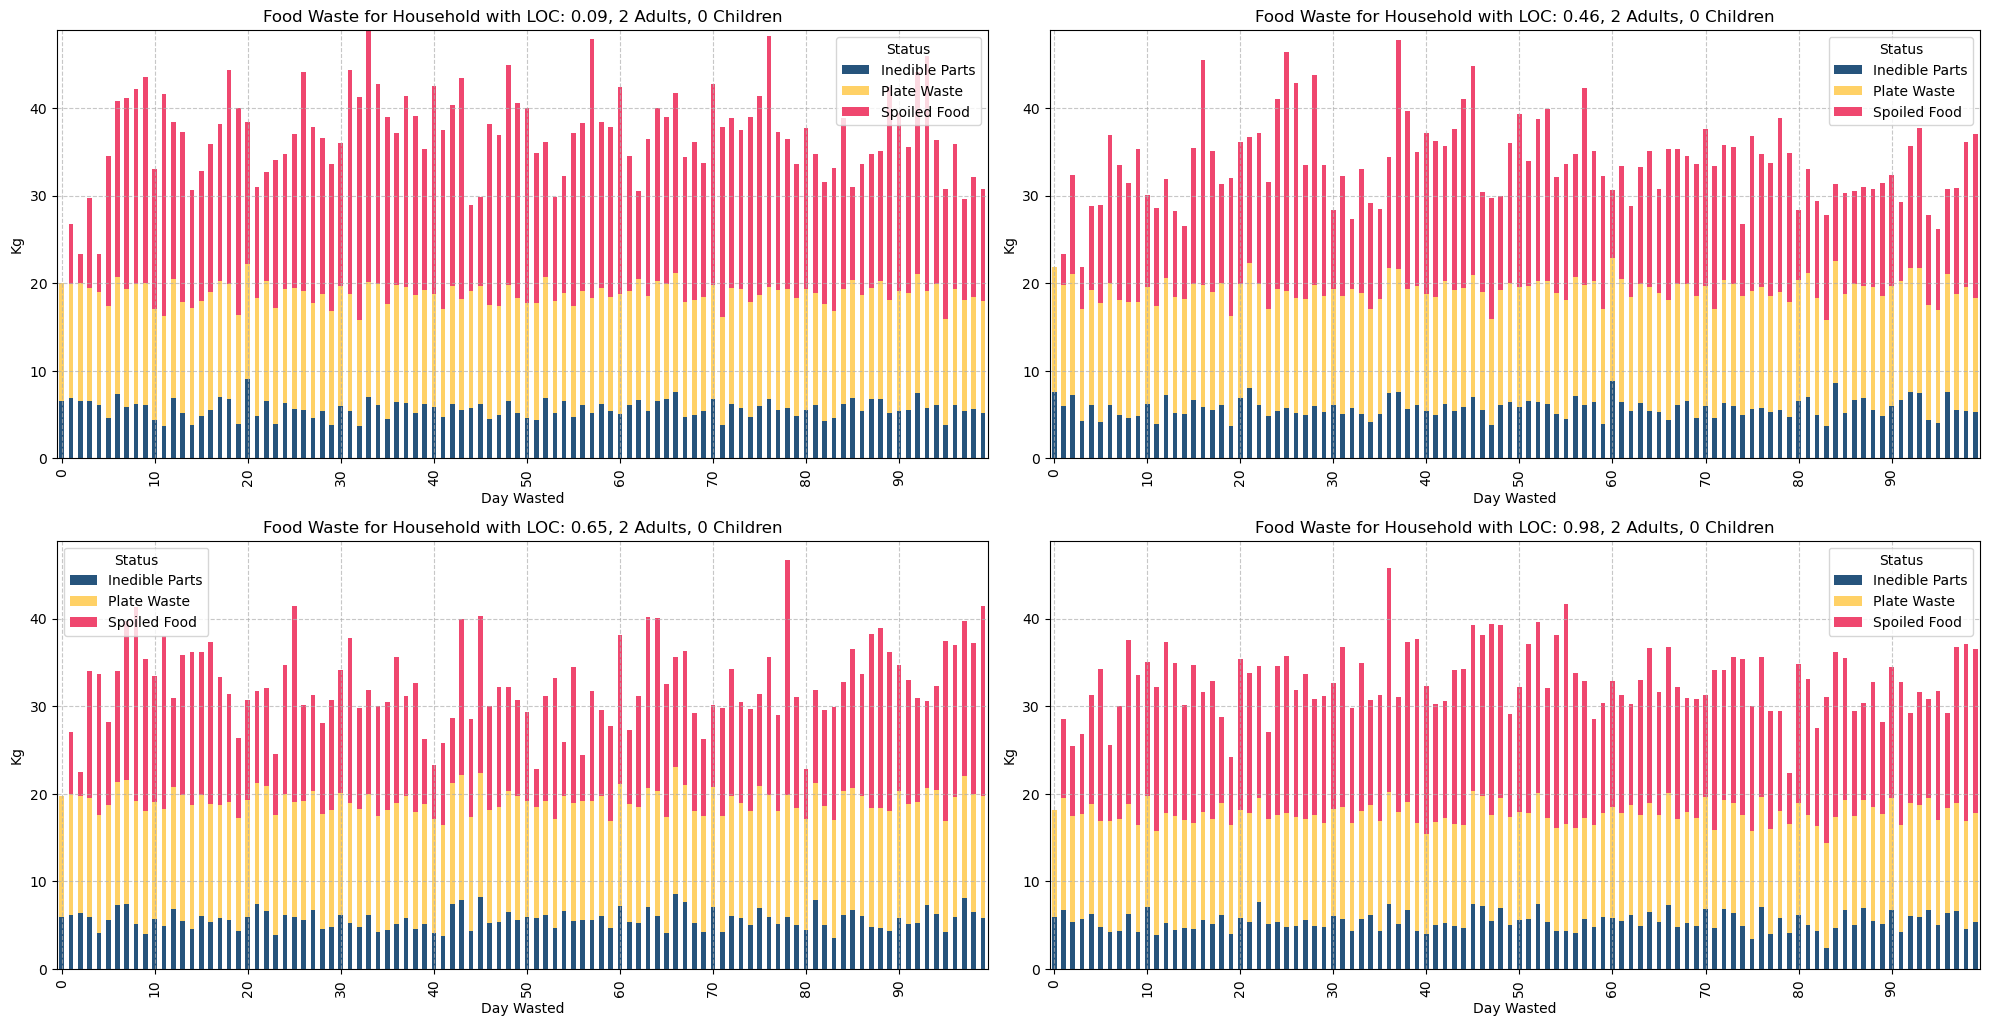

[98, 61, 95, 15]


In [24]:

plot_waste_by_waste_type(data["2a_0k"],concern_ranges, "Kg")
#plot_waste_by_waste_type(data["2a_0k"],concern_ranges, "Kg")
#plot_waste_by_waste_type(data["2a_0k"],concern_ranges, "Kg")
#plot_waste_by_waste_type(data["2a_0k"],concern_ranges, "Kg")
#plot_waste_by_waste_type(data["2a_0k"],concern_ranges, "Kg")

In [ ]:

plot_waste_by_waste_type(data["2a_4k"],concern_ranges, "Kg")
plot_waste_by_waste_type(data["2a_4k"],concern_ranges, "Kg")
plot_waste_by_waste_type(data["2a_4k"],concern_ranges, "Kg")
plot_waste_by_waste_type(data["2a_4k"],concern_ranges, "Kg")
plot_waste_by_waste_type(data["2a_4k"],concern_ranges, "Kg")

In [ ]:
plot_waste_by_waste_type(data["2a_0k"],concern_ranges, "Kg")

In [ ]:
plot_waste_by_waste_type(data["2a_2k"],concern_ranges, "Kg")

In [ ]:
plot_waste_by_waste_type(data["2a_2k"],concern_ranges, "Kg")

In [ ]:
plot_waste_by_waste_type(data["2a_0k"],concern_ranges, "Kg")

### Calculation: Average waste in kg per household size daily

In [ ]:
import pandas as pd
import dask.dataframe as dd

def get_average_daily(data, category: str ):
    # Define intervals
    individual_data = {main_folder: {"Mean": [], "Std": []} for main_folder in data.keys()}

    for main_folder, dfs in data.items():
        
        df = dfs[category][dfs[category]['Day'] >= 14].compute()
       
        total_eaten = df['Kg'].sum()
        average = total_eaten / (DAYS - 14)

        new_row = {"Mean": [average], "Std":[]}
        individual_data[main_folder] = new_row
        
    return individual_data


In [ ]:
sorted_wasted["2a_0k"].head()

### Stacked Barchart: servings: Waste per type for individual family

In [ ]:
hhsize = "2a_0k"
# Assuming df is already loaded with the Dask DataFrame
df = data[hhsize]["wasted"]
household_id = "0_0"  # Set the desired household ID
filtered_df = df[(df['House'] == household_id) & (df["Kg"] > 0)]

# Group and aggregate the data
grouped_df = filtered_df.groupby('Day Wasted')[food_categories].sum().compute().sort_index()

# Get Level of Concern
loc = data[hhsize]["config"][data[hhsize]["config"]["House"] == household_id]["LvlOfConcern"].compute().iloc[0]

# Plotting the stacked bar chart
plt.figure(figsize=(14, 8))
ax = grouped_df.plot(kind='bar', stacked=True, color=[color_mapping.get(cat, 'gray') for cat in grouped_df.columns], ax=plt.gca())
plt.title(f'Food Waste for Household: {hhsize[0]} Adults, {hhsize[-2]} Children with LOC: {loc:.2f} over {DAYS} Days')
plt.xlabel('Day Wasted')
plt.ylabel('Servings of Food Wasted')
plt.legend(title='Food Categories')
plt.xticks(range(0, len(grouped_df), 10))
plt.tight_layout()
plt.show()

### Calculation: Waste per type in kg for individual family over 100 days

In [ ]:
df = data[hhsize]["wasted"]
for item in food_categories:
    category_sum = df[(df['House'] == household_id) & (df["Kg"] > 0)]
    category_sum = category_sum[item].sum().compute()
    conversion_factor = lookup_df.loc[lookup_df["Type"] == item, "Servings_to_Kg"].values[0]
    category_sum_kg = category_sum * conversion_factor
    print(f"{item}: {category_sum_kg:.2f} kg")


### Stacked Barplot: Kg: Food groups individual family over time

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

food_categories = [
    'Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 'Dry Foods & Baked Goods',
    'Snacks, Condiments, Liquids, Oils, Grease, & Other', 'Store-Prepared Items'
]

lookup_df = pd.DataFrame({
    'Type': ['Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 'Dry Foods & Baked Goods', 
             'Snacks, Condiments, Liquids, Oils, Grease, & Other', 'Store-Prepared Items'],
    'Servings_to_Kg': [0.09, 0.109, 0.116, 0.065, 0.095, 0.095],
    "Color":["#1E3A8A", "#0EA5E9", "#F97316", "#DB2777", "#84CC16", "#FACC15"]
})

def plot_food_group_waste_hh(df, hhID, runID):

    df_filtered = df[(df['House'] == hhID) & (df["Kg"] > 0) & (df["run_id"] == runID)].compute()
    df_filtered = df_filtered.groupby(['Day Wasted'])[food_categories].sum().reset_index()

    servings_to_kg_dict = lookup_df.set_index('Type')['Servings_to_Kg'].to_dict()
    df_food_categories = df_filtered[food_categories]
    df_food_categories = df_food_categories.multiply(pd.Series(servings_to_kg_dict))
    df_food_categories = df_food_categories.reset_index()
    df_food_categories = df_food_categories.rename(columns={'index': 'Day Wasted'})

    
    food_categories_full = {
        'Meat & Fish': 'Meat & Fish',
        'Dairy & Eggs': 'Dairy & Eggs',
        'Fruits & Vegetables': 'Fruits & Vegetables',
        'Dry Foods & Baked Goods': 'Dry Foods & Baked Goods',
        'Snacks': 'Snacks, Condiments, Liquids, Oils, Grease, & Other',
        'Store-Prepared Items': 'Store-Prepared Items'
    }

    colors = [lookup_df[lookup_df['Type'] == food_categories_full[cat]]['Color'].values[0] for cat in food_categories_full]
    
    plt.figure(figsize=(20, 10), dpi=300)        
    ax = df_food_categories.plot(kind='bar', stacked=True,figsize=(20, 10), color=colors, x='Day Wasted')
  
    plt.xlabel("Day", fontsize=18)
    plt.xlim(0, DAYS)
    plt.xticks(range(0, DAYS + 1, 10)) 
    plt.ylabel("Kg", fontsize=18)
    plt.legend(title='Food Groups', fontsize=18, title_fontsize=18, 
               loc='upper right', bbox_to_anchor=(1, 1))
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [53]:
## POSTEr VERSION
def plot_food_group_waste_hh(df, hhID, runID):

    df_filtered = df[(df['House'] == hhID) & (df["Kg"] > 0) & (df["run_id"] == runID)].compute()
    df_filtered = df_filtered.groupby(['Day Wasted'])[food_categories].sum().reset_index()

    servings_to_kg_dict = lookup_df.set_index('Type')['Servings_to_Kg'].to_dict()
    df_food_categories = df_filtered[food_categories]
    df_food_categories = df_food_categories.multiply(pd.Series(servings_to_kg_dict))
    df_food_categories = df_food_categories.reset_index()
    df_food_categories = df_food_categories.rename(columns={'index': 'Day Wasted'})

    
    food_categories_full = {
        'Meat & Fish': 'Meat & Fish',
        'Dairy & Eggs': 'Dairy & Eggs',
        'Fruits & Vegetables': 'Fruits & Vegetables',
        'Dry Foods & Baked Goods': 'Dry Foods & Baked Goods',
        'Snacks': 'Snacks, Condiments, Liquids, Oils, Grease, & Other',
        'Store-Prepared Items': 'Store-Prepared Items'
    }

    colors = [lookup_df[lookup_df['Type'] == food_categories_full[cat]]['Color'].values[0] for cat in food_categories_full]
    
    plt.figure(figsize=(20, 15), dpi=300)        
    ax = df_food_categories.plot(kind='bar', stacked=True, color=colors, x='Day Wasted', ax=plt.gca(),legend=False)
  
    plt.xlabel("Day", fontsize=35)
    plt.xlim(0, DAYS)
    plt.xticks(range(0, DAYS + 1, 10)) 
    plt.ylabel("Kg", fontsize=35)
    plt.tick_params(axis='both', which='major', labelsize=35)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


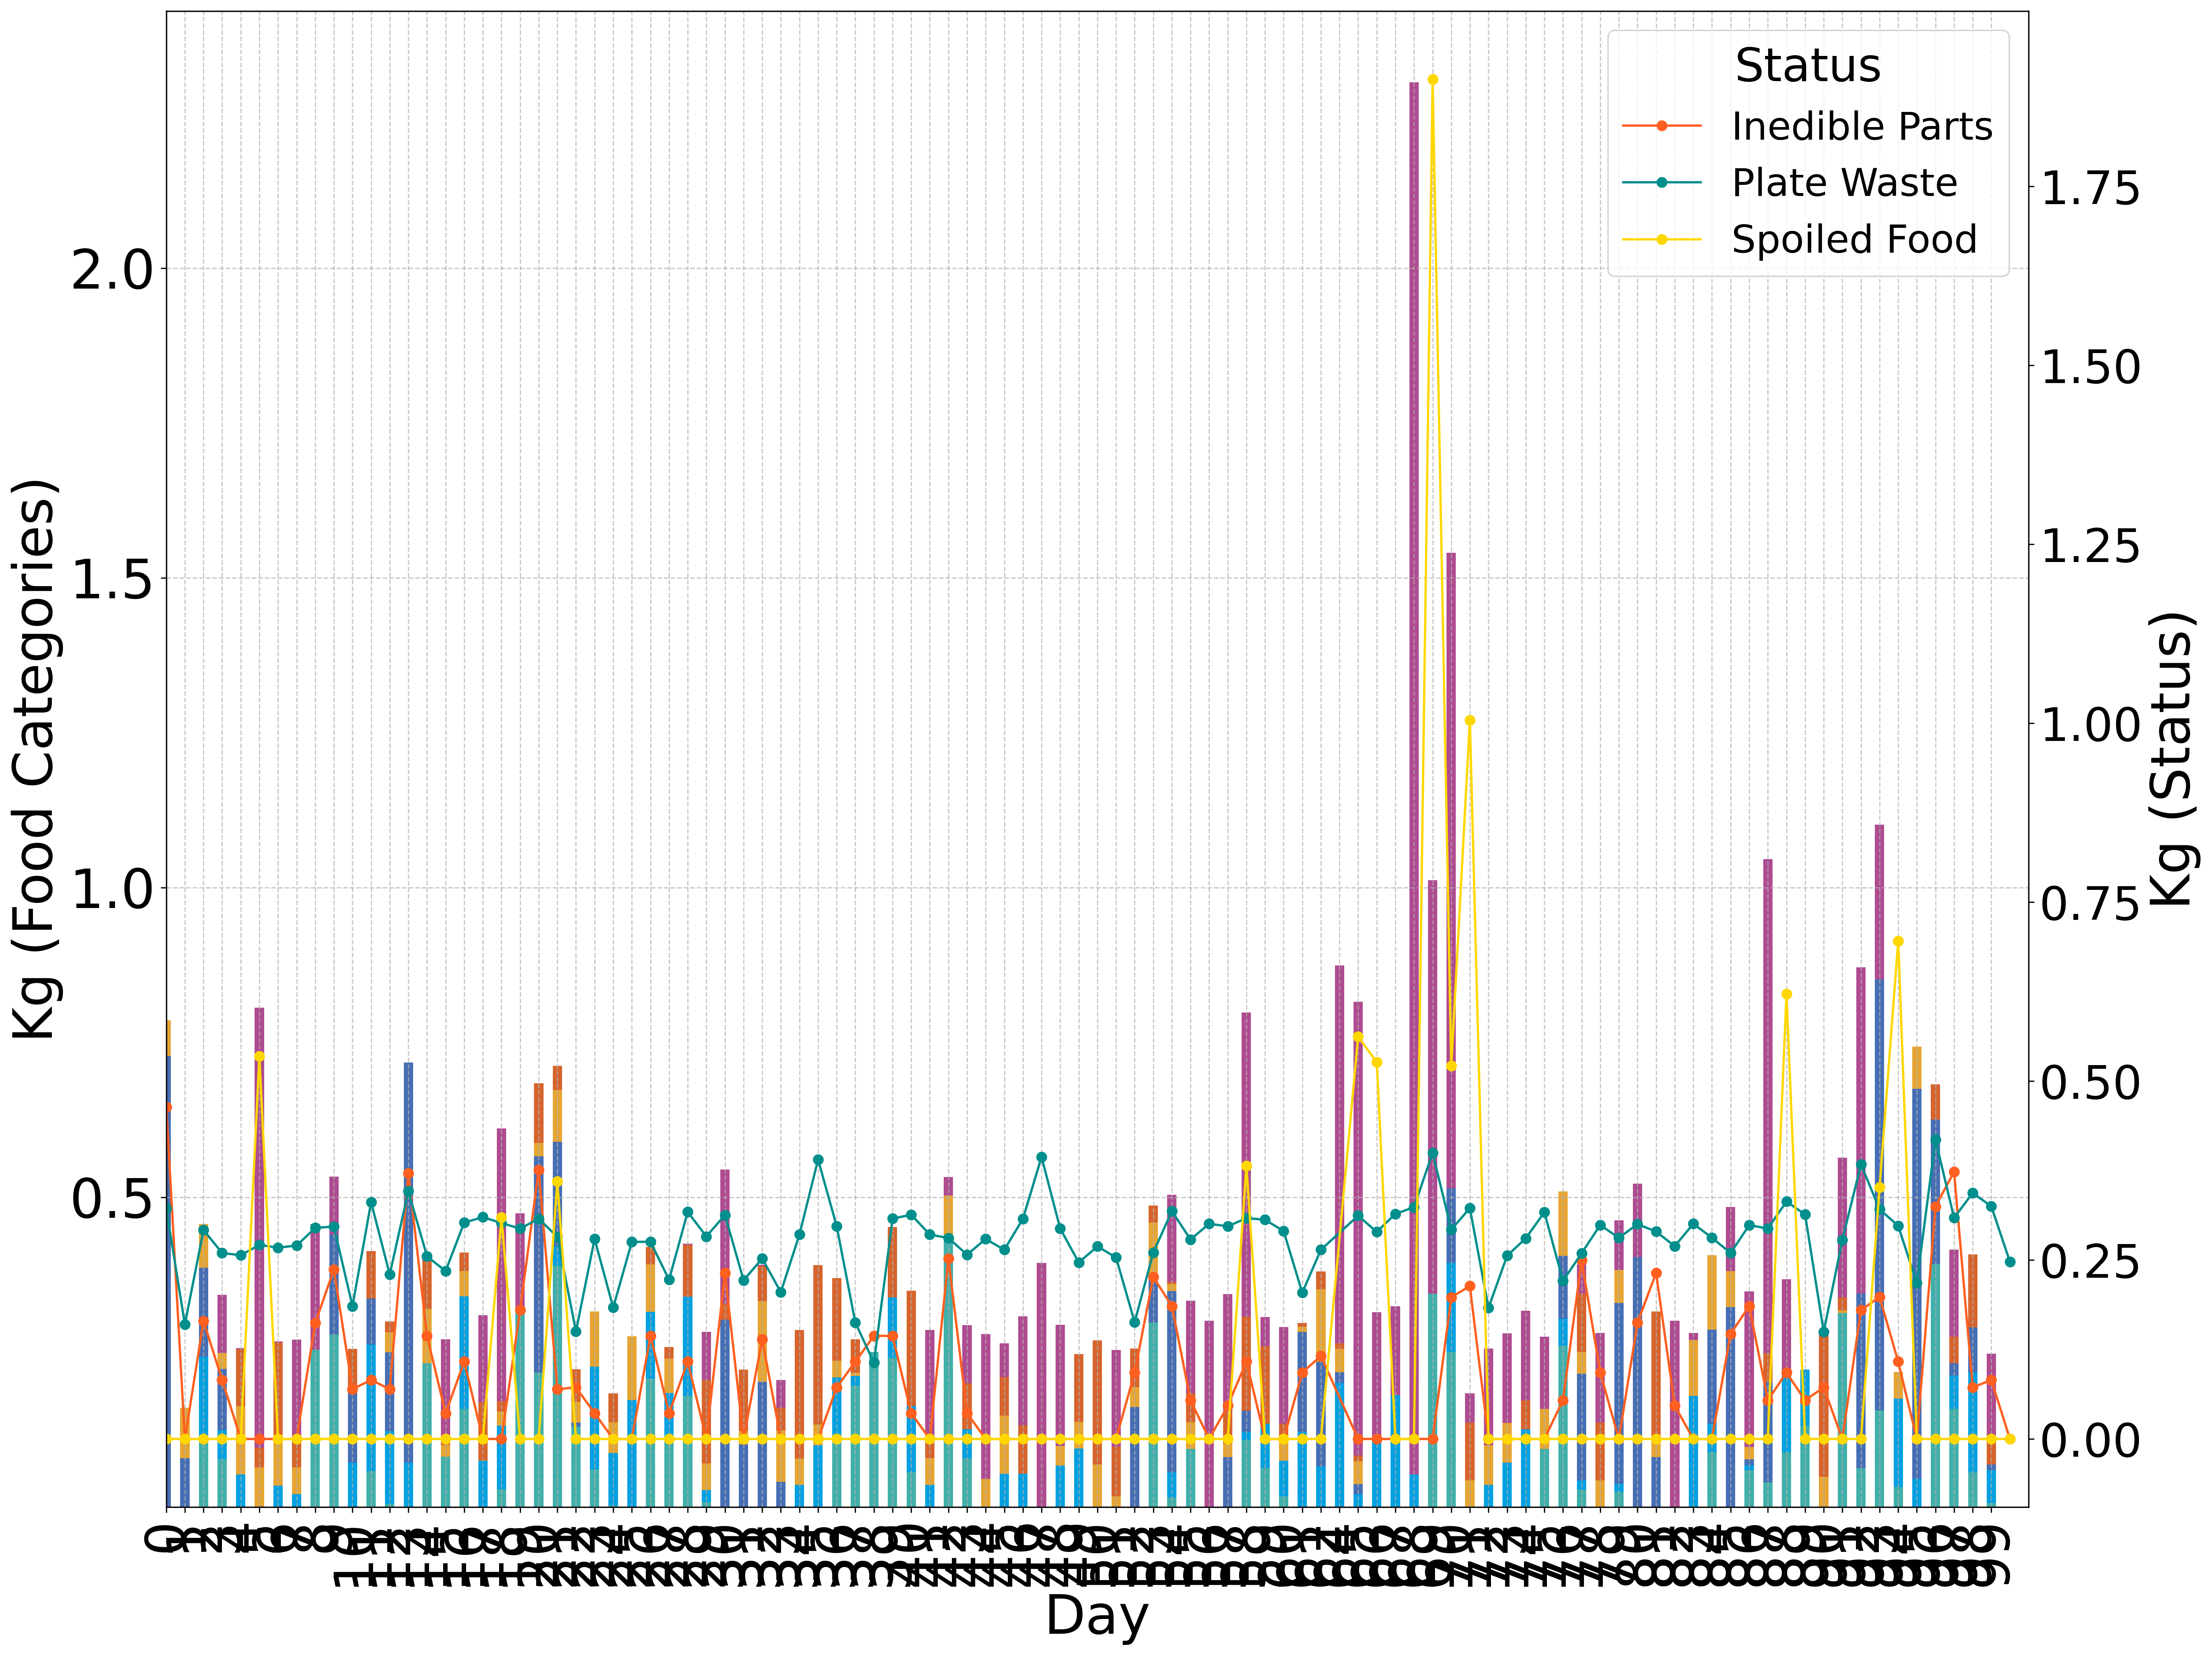

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

def plot_food_group_waste_hh_with_status(df, hhID, runID):
    df_filtered = df[(df['House'] == hhID) & (df["Kg"] > 0) & (df["run_id"] == runID)].compute()
    
    # Aggregate food category waste
    df_food_categories = df_filtered.groupby(['Day Wasted'])[food_categories].sum().reset_index()
    
    # Convert servings to kg
    servings_to_kg_dict = lookup_df.set_index('Type')['Servings_to_Kg'].to_dict()
    df_food_categories[food_categories] = df_food_categories[food_categories].multiply(pd.Series(servings_to_kg_dict))
    
    # Aggregate status waste
    df_status = df_filtered.groupby(['Day Wasted', 'Status'])["Kg"].sum().unstack(fill_value=0).reindex(columns=status_colors.keys(), fill_value=0)

    # Get colors
    food_categories_full = {
        'Meat & Fish': 'Meat & Fish',
        'Dairy & Eggs': 'Dairy & Eggs',
        'Fruits & Vegetables': 'Fruits & Vegetables',
        'Dry Foods & Baked Goods': 'Dry Foods & Baked Goods',
        'Snacks': 'Snacks, Condiments, Liquids, Oils, Grease, & Other',
        'Store-Prepared Items': 'Store-Prepared Items'
    }
    food_colors = [lookup_df[lookup_df['Type'] == food_categories_full[cat]]['Color'].values[0] for cat in food_categories_full]

    # Plot
    fig, ax1 = plt.subplots(figsize=(20, 15), dpi=300)

    # Stacked Bar Chart (Food Categories)
    df_food_categories.plot(kind='bar', stacked=True, color=food_colors, x='Day Wasted', ax=ax1, legend=False)

    # Line Plot (Status) on secondary y-axis
    ax2 = ax1.twinx()
    for status in df_status.columns:
        ax2.plot(df_status.index, df_status[status], marker='o', linestyle='-', label=status, color=status_colors.get(status, 'black'))

    # Labels and formatting
    ax1.set_xlabel("Day", fontsize=35)
    ax1.set_xlim(0, DAYS)
    ax1.set_ylabel("Kg (Food Categories)", fontsize=35)
    ax1.tick_params(axis='both', which='major', labelsize=35)
    ax1.grid(True, linestyle='--', alpha=0.7)

    ax2.set_ylabel("Kg (Status)", fontsize=35)
    ax2.tick_params(axis='y', labelsize=30)

    # Legend
    ax2.legend(title="Status", fontsize=25, title_fontsize=30, loc='upper right')

    plt.tight_layout()
    plt.show()


plot_food_group_waste_hh_with_status(data["2a_0k"]["wasted"], 0,0)

In [ ]:
 hh_wasted.plot(kind='bar', stacked=True, color=[status_colors.get(status, 'gray') for status in hh_wasted.columns], ax=plt.gca(), legend=False)
    
    plt.xlabel("Day Wasted", fontsize=35)
    plt.xlim(0,DAYS)
    plt.xticks(range(0, DAYS + 1, 10)) 
    plt.ylabel("Kg", fontsize=35)
    #plt.legend(title="Status", fontsize=18, title_fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=35)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

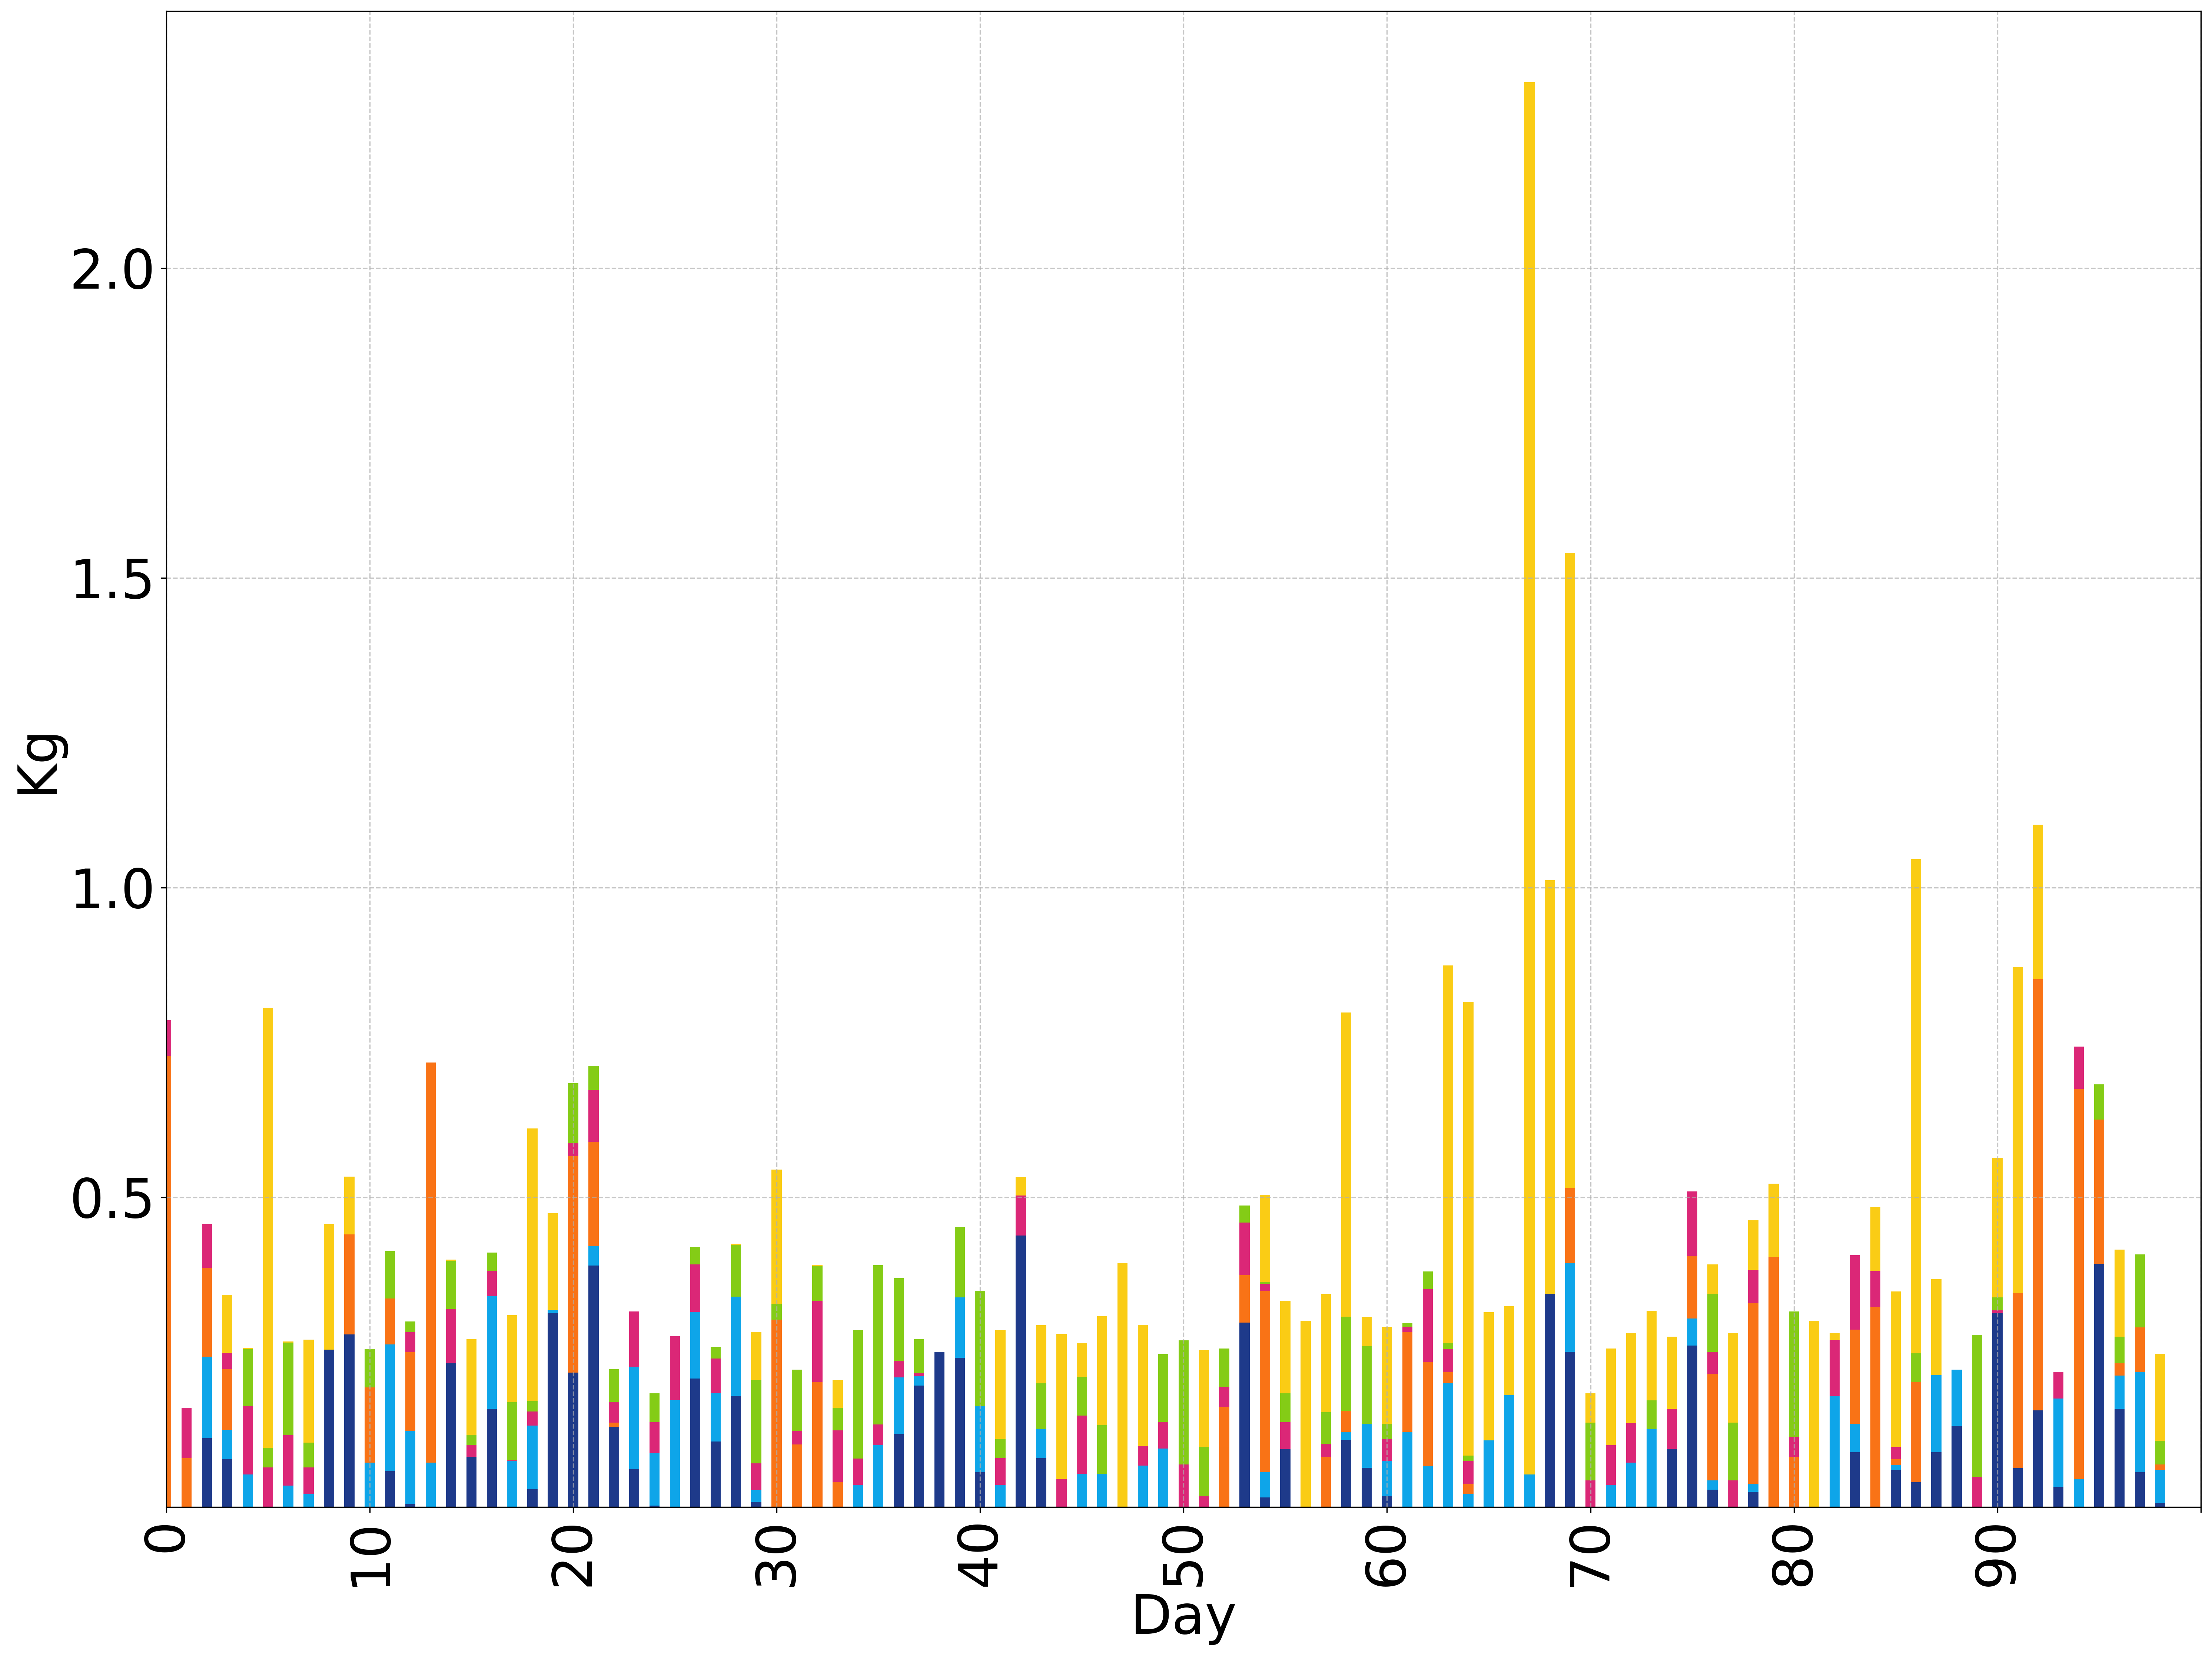

In [54]:
plot_food_group_waste_hh(data["2a_0k"]["wasted"], 0,0)

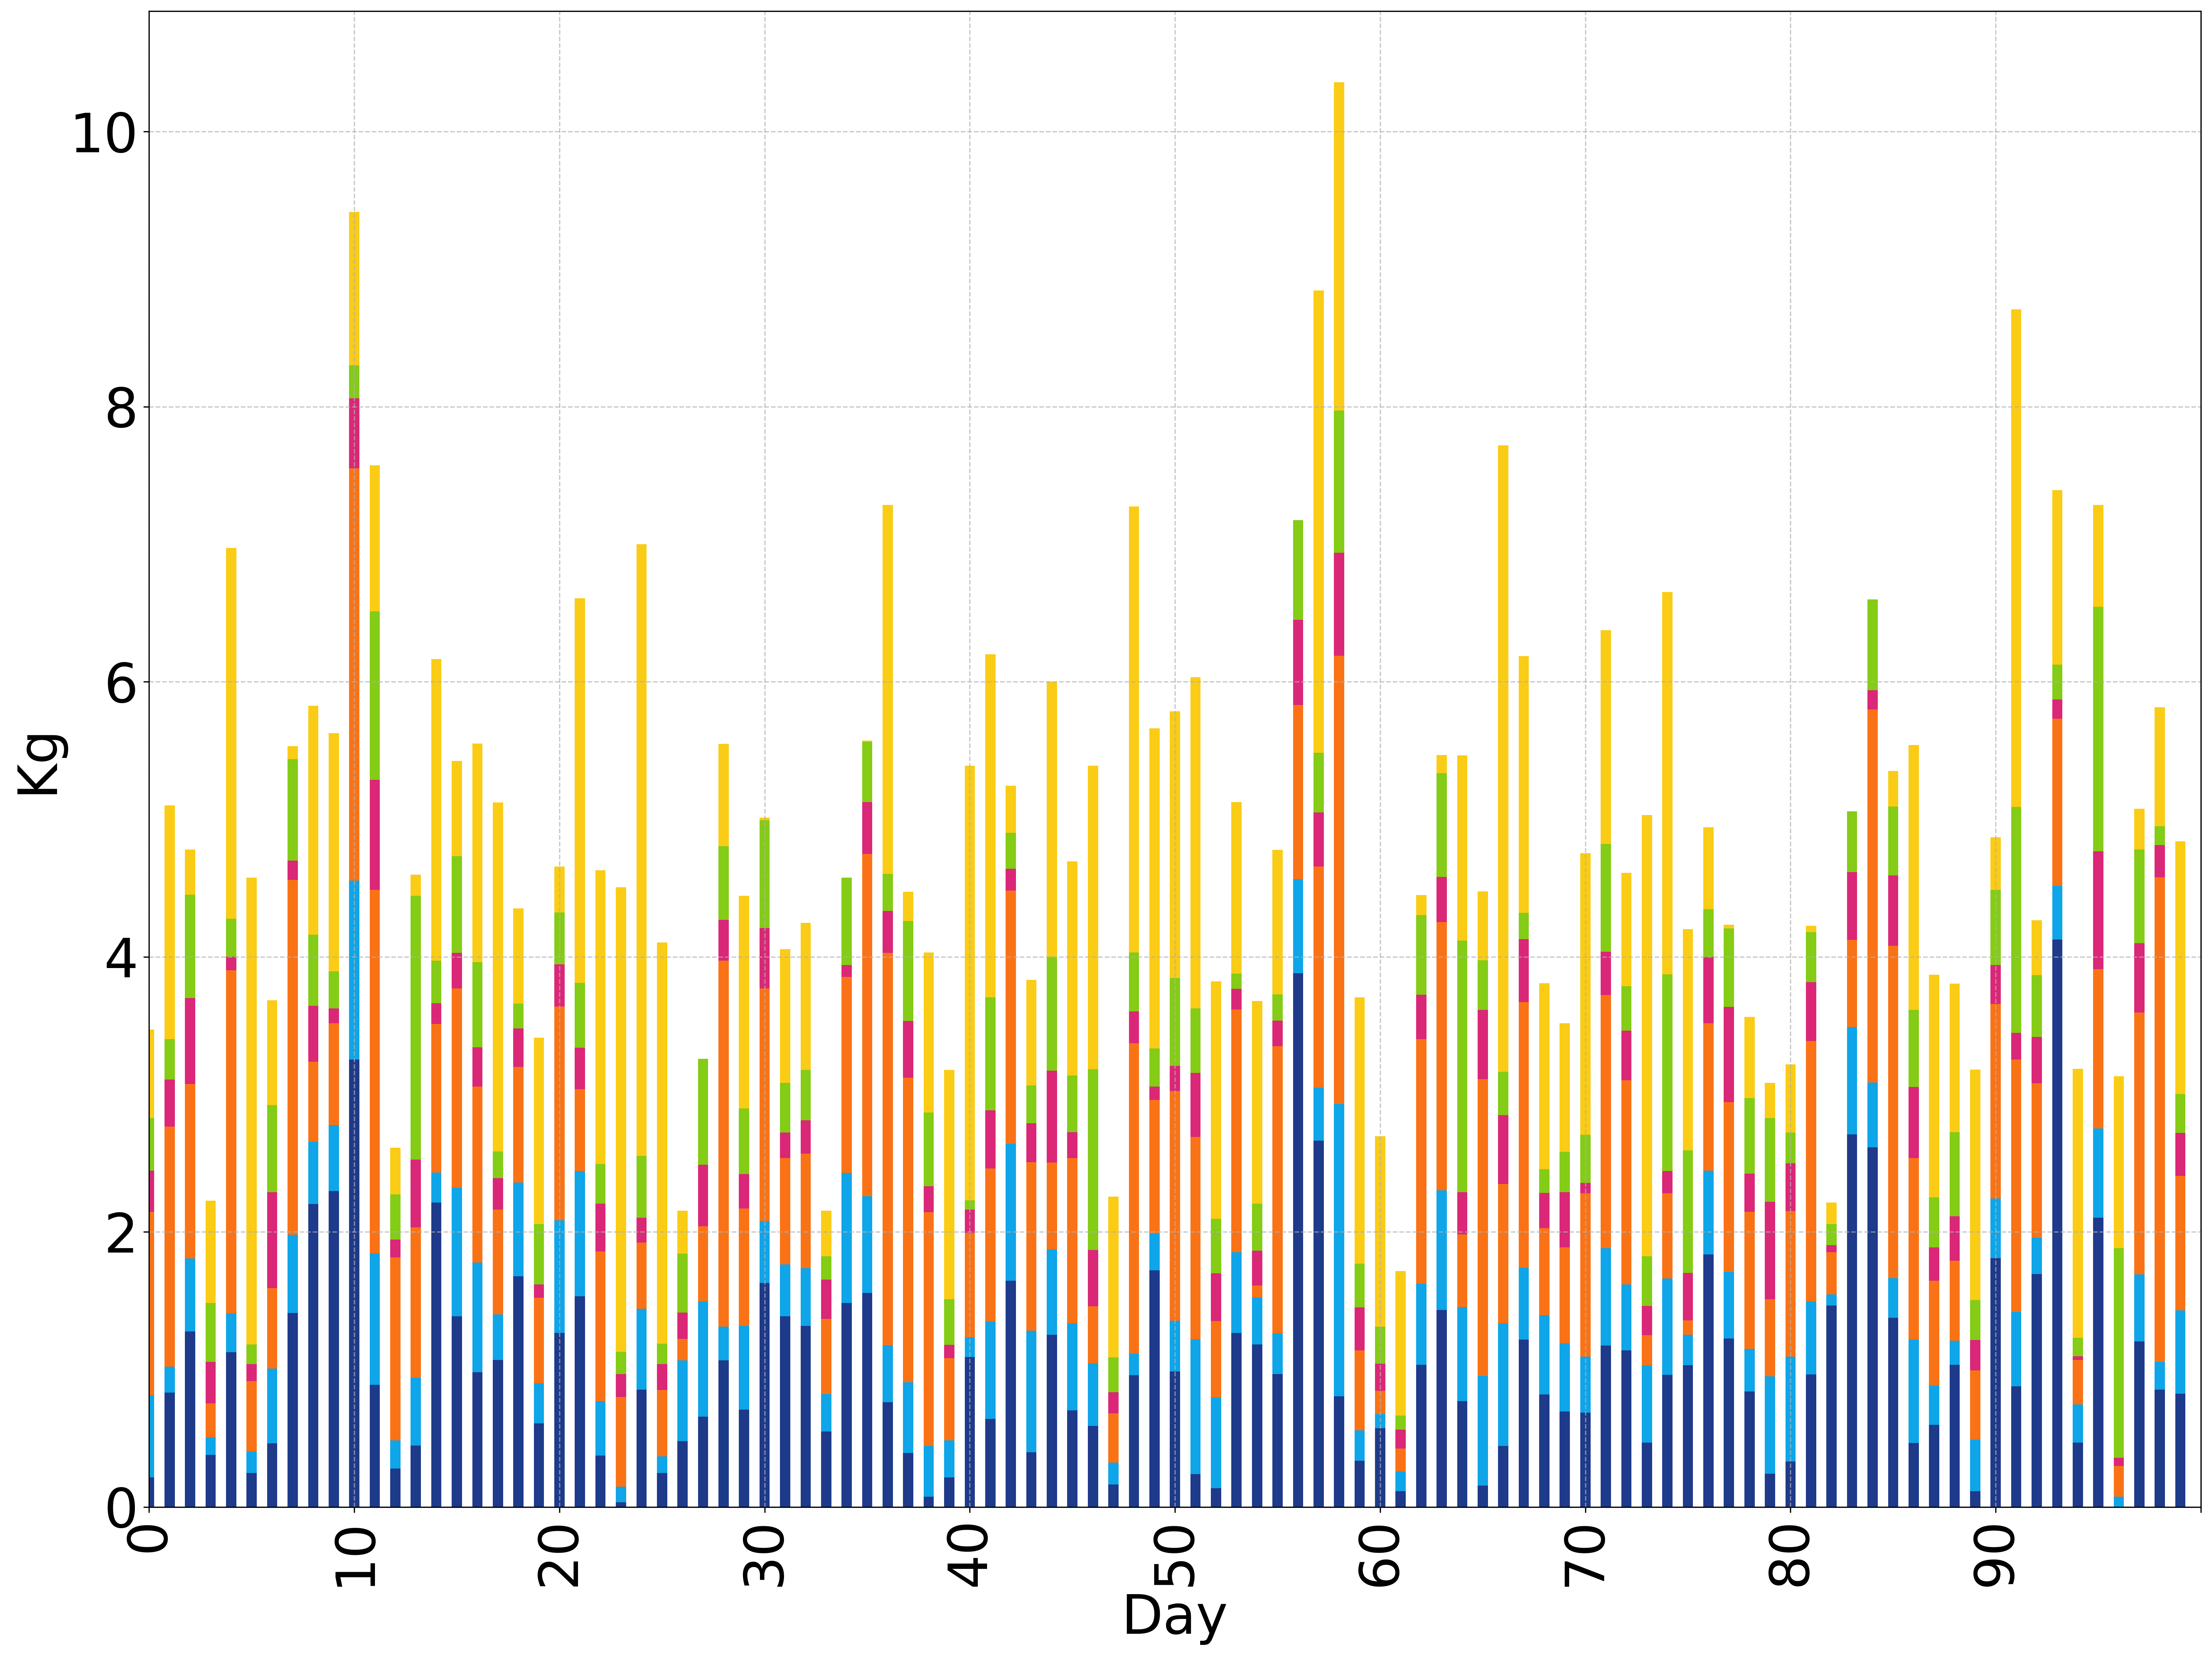

In [55]:
plot_food_group_waste_hh(data["2a_6k"]["wasted"], 0,1)

### Waste per type in USD for individual family


In [ ]:
hhsize = "2a_0k"
df = data[hhsize]["wasted"]
household_id = "49_36"
filtered_df = df[(df['House'] == household_id) & (df["Kg"] > 0)]
grouped_df = filtered_df.groupby('Day')["Price"].sum().compute().sort_index()
loc = data[hhsize]["config"][data[hhsize]["config"]["House"] == household_id]["LvlOfConcern"].compute().iloc[0]

plt.figure(figsize=(14, 8))
plt.plot(grouped_df.index, grouped_df.values, label='Daily Cost of Food Waste', color='blue', marker='o')
plt.title(f'Food Waste Cost for Household {hhsize}:{household_id} with LOC: {loc:.2f} Over {DAYS} Days')
plt.xlabel('Day Wasted')
plt.ylabel('USD of Food Wasted')
plt.legend(title='Legend')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Waste over HHSize and LOC

### Waste type values per hhsize and loc using Radaplot
- sum starting from day 14
- per person/per household

In [12]:
import pandas as pd
from dask.diagnostics import ProgressBar

def calculate_waste_quant(data, bins: list[float], per_capita: bool, metric: str):
    # Define intervals with the bins provided
    interval_labels = pd.IntervalIndex.from_breaks(bins, closed='right')
    stats = {main_folder: pd.DataFrame() for main_folder in data.keys()}

    for main_folder, dfs in data.items():
        config_df = dfs['config'].compute()
        config_df['ConcernInterval'] = pd.cut(config_df['LvlOfConcern'], bins=interval_labels)
        df = dfs["wasted"][dfs["wasted"]['Day Wasted'] >= 14].compute()
        # Merge on 'House', ensuring both DataFrames have this column
        merged_df = pd.merge(df, config_df[['House', 'ConcernInterval', 'Adults', 'Children']],
                             on='House', how='inner')
        for idx, interval in enumerate(interval_labels):
            group = config_df[config_df['ConcernInterval'] == interval]
            household_ids = group['House'].tolist()
            interval_df = merged_df[merged_df['House'].isin(household_ids)]
            grouped_df = interval_df.groupby(["Status"])[metric].sum()

            # Calculate total people based on the given interval group
            if per_capita:
                total_people = group['Adults'].sum() + group['Children'].sum()
            else:
                total_people = len(group)

            if not group.empty and not interval_df.empty:
                for item in ["Inedible Parts", "Spoiled Food", "Plate Waste"]:
                    total = interval_df[interval_df["Status"] == item][metric].sum()
                    avg = total / (total_people * (DAYS - 14)) if total_people > 0 else 0
                    stats[main_folder].at[idx, item] = total
                    stats[main_folder].at[idx, item+"Avg"] = avg


    return stats


In [15]:
import pandas as pd
from dask.diagnostics import ProgressBar

def calculate_waste_quant(data, bins: list[float], per_capita: bool, metric: str):
    # Define intervals with the bins provided
    interval_labels = pd.IntervalIndex.from_breaks(bins, closed='right')
    stats = {main_folder: pd.DataFrame() for main_folder in data.keys()}

    for main_folder, dfs in data.items():
        config_df = dfs['config'].compute()
        config_df['ConcernInterval'] = pd.cut(config_df['LvlOfConcern'], bins=interval_labels)
        df = dfs["wasted"][dfs["wasted"]['Day Wasted'] >= 14].compute()
        # Merge on 'House', ensuring both DataFrames have this column
        merged_df = pd.merge(df, config_df[['House', 'ConcernInterval', 'Adults', 'Children']],
                             on='House', how='inner')
        for idx, interval in enumerate(interval_labels):
            group = config_df[config_df['ConcernInterval'] == interval]
            household_ids = group['House'].tolist()
            interval_df = merged_df[merged_df['House'].isin(household_ids)]
            grouped_df = interval_df.groupby(["Status"])[metric].sum()

            # Calculate total people based on the given interval group
            if per_capita:
                total_people = group['Adults'].sum() + group['Children'].sum()
            else:
                total_people = len(group)

            if not group.empty and not interval_df.empty:
                for item in ["Inedible Parts", "Spoiled Food", "Plate Waste"]:
                    total = interval_df[interval_df["Status"] == item][metric].sum()
                    avg = total / (total_people * (DAYS - 14)) if total_people > 0 else 0
                    stats[main_folder].at[idx, item] = total
                    stats[main_folder].at[idx, item+"Avg"] = avg


    return stats

In [16]:
bins = [i / 4 for i in range(5)] 

# Define intervals as a list of strings in the format 'value0 - value1'
intervals = [
    '0% - 25%',
    '25% - 50%',
    '50% - 75%',
    '75% - 100%'
]

In [19]:
wastetypes = calculate_waste_quant(data=data, bins=bins,per_capita=False,metric="Kg")

: 

In [ ]:
wastetypes_pp = calculate_waste_quant(data=data, bins=bins,per_capita=True,metric="Kg")

In [ ]:
wastetypes["2a_0k"]

In [ ]:
wastetypes["2a_2k"]

In [ ]:
wastetypes["2a_4k"]

In [ ]:
wastetypes["2a_6k"]

### Radarchart: Waste type sorted by LOC and HHsize (grouped plots)

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Categories for radar chart
categories = ['Inedible PartsAvg', 'Spoiled FoodAvg', 'Plate WasteAvg']
num_vars = len(categories)

# Set up angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Find the global maximum value to ensure consistent scaling
global_max = 0
for key in main_folders:
    df = wastetypes[key]
    df_max = df[categories].max().max()
    if df_max > global_max:
        global_max = df_max

# Create a radar plot for each DataFrame
fig, axs = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(polar=True))  # 2x2 grid for subplots
axs = axs.flatten()  # Flatten the 2x2 array for easy iteration

# Iterate over each dataset and subplot
for i, key in enumerate(main_folders):
    ax = axs[i]
    df = wastetypes[key]
    df = df.sort_index()

    # Iterate over each row to plot
    for idx, row in df.iterrows():
        # Extract the values for each row
        values = row[categories].tolist()
        values += values[:1]  # Close the circle
        color_idx = idx % len(colors)  # Rotate through the custom colors

        # Use the custom color for each plot
        ax.plot(angles, values, linewidth=2, linestyle='solid', label="LOC:" + str(object=intervals[idx]), color=colors[color_idx])
        ax.fill(angles, values, alpha=0.2, color=colors[color_idx])

    # Add grey lines forming a triangle
    rings = np.linspace(0, global_max, 4)  # Adjust the number of rings and their positions

    # Customize the radar chart for each subplot
    ax.set_yticks(rings)  # Set y-ticks based on the calculated rings
    ax.set_yticklabels([f'{ring:.2f} kg' for ring in rings], fontsize=10)  # Set y-tick labels with 'kg'

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['Inedible Parts', 'Spoiled Food', 'Plate Waste'], fontsize=13)
    ax.set_title(f'2 Adults, {key[-2]} children', fontsize=14)
    
    # Add the legend inside the subplot
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


NameError: name 'wastetypes' is not defined

### Radarchart: Waste type sorted by LOC and HHsize (individual plots)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Categories for radar chart
categories = ['Inedible PartsAvg', 'Spoiled FoodAvg', 'Plate WasteAvg']
num_vars = len(categories)

# Set up angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Find the global maximum value to ensure consistent scaling
global_max = 0
for key in main_folders:
    df = wastetypes[key]
    df_max = df[categories].max().max()
    if df_max > global_max:
        global_max = df_max

# Iterate over each dataset and create a separate radar plot for each
for i, key in enumerate(main_folders):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))  # Create a new figure for each dataset
    df = wastetypes[key]
    df = df.sort_index()

    # Iterate over each row to plot
    for idx, row in df.iterrows():
        # Extract the values for each row
        values = row[categories].tolist()
        values += values[:1]  # Close the circle
        color_idx = idx % len(colors)  # Rotate through the custom colors

        # Use the custom color for each plot
        ax.plot(angles, values, linewidth=2, linestyle='solid', label="LOC:" + str(intervals[idx]), color=colors[color_idx])
        ax.fill(angles, values, alpha=0.2, color=colors[color_idx])

    # Add grey lines forming a triangle
    rings = np.linspace(0, global_max, 4)  # Adjust the number of rings and their positions

    # Customize the radar chart for the subplot
    ax.set_yticks(rings)  # Set y-ticks based on the calculated rings
    ax.set_yticklabels([f'{ring:.2f} kg' for ring in rings], fontsize=10)  # Set y-tick labels with 'kg'

    # Customize category labels
    ax.set_xticks(angles[:-1])
    #for 0-4
    #ax.set_xticklabels(['Inedible Parts                                  ', '\n\n\n\n\n\n\n\n\n          Spoiled Food ', '              Plate Waste\n\n\n\n\n\n'], fontsize=11, color='#333', weight='bold')
    #for 6 
    ax.set_xticklabels(['Inedible Parts                                  ', '\n\n\n\n\n\n             Spoiled Food ', '              Plate Waste \n'], fontsize=11, color='#333', weight='bold')
    # Fine-tune radial ticks for better spacing and readability
    ax.tick_params(axis='y', labelsize=10, color='gray')
    ax.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

    # Add the legend, slightly outside the chart
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=10)


    # Adjust layout and show each individual plot
    plt.tight_layout(pad=3)  # Add padding for breathing room
    plt.savefig(f'radar_chart_{key}.png', dpi=300)  # Save plot with 300 DPI
    plt.close()  # Close the figure to free up memory


### Waste radarplot for composition of food group in different waste types

In [ ]:
df = data["2a_0k"]["wasted"]# List of columns to sum
columns_to_sum = [
    'Meat & Fish',
    'Dairy & Eggs',
    'Fruits & Vegetables',
    'Dry Foods & Baked Goods',
    'Snacks, Condiments, Liquids, Oils, Grease, & Other',
    'Store-Prepared Items'
]

# Group by Status and sum the values for each category
summary = df.groupby('Status')[columns_to_sum].sum().reset_index()



In [ ]:
#summary = summary.compute()

summary.columns

In [ ]:
data[key]["wasted"].head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the categories for the radar chart
categories = ['Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', \
    'Dry Foods & Baked Goods', 'Snacks, Condiments, Liquids, Oils, Grease, & Other', 'Store-Prepared Items']
num_vars = len(categories)

# Set up angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Find the global maximum value to ensure consistent scaling
global_max = 0
for key in main_folders:
    df = data[key]["wasted"]
    df_max = df[categories].sum().max().compute() 
    df_max = df_max/(50*100*100)
    if df_max > global_max:
        global_max = df_max

# Create a radar plot for each DataFrame
fig, axs = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(polar=True))  # 2x2 grid for subplots
axs = axs.flatten()  # Flatten the 2x2 array for easy iteration

# Iterate over each dataset and subplot
for i, key in enumerate(main_folders):
    ax = axs[i]
    df = data[key]["wasted"]
    
    # Compute summary values per status
    summary = df.groupby('Status')[categories].sum().compute().reset_index()
    summary[categories] = summary[categories]/(50*100*100) #TODO make dynamic
    # Plot each status
    for idx, row in summary.iterrows():
        # Extract the values for each category
        values = row[categories].tolist()
        values += values[:1]  # Close the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Status'])
        ax.fill(angles, values, alpha=0.2)

    # Add grey lines forming a triangle
    rings = np.linspace(0, global_max, 4)  # Adjust the number of rings and their positions
    
    # Customize the radar chart for each subplot
    ax.set_yticks(rings)  # Set y-ticks
    ax.set_yticklabels([f'{ring:.1f}' for ring in rings], fontsize=10)  # Set y-tick labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=13)
    ax.set_title(f'2 Adults, {key[-2]} children', fontsize=14)
    
    # Add the legend inside the subplot
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Calculation: Distribution of waste type over all households (%, kg, pp)

In [ ]:
import dask.dataframe as dd
import pandas as pd

##total people
dataframes = []
for folder in main_folders:
    dff = data[folder]['config']
    
    dataframes.append(dff)
    
dff = dd.concat(dataframes).compute()
total_people = dff["Adults"].sum() + dff["Children"].sum()

total_people

## load all wasted data
dataframes = []
for folder in main_folders:
    df = data[folder]['wasted']
    df = df[df["Kg"] > 0]
    
    dataframes.append(df)
df = dd.concat(dataframes)



wastetype_kg = df.groupby(by="Status")["Kg"].sum().compute()

# Convert Series to DataFrame
status_df = wastetype_kg.reset_index()
status_df.columns = ['Status', 'Kg']

# Calculate the total
total = status_df['Kg'].sum()

# Compute percentages
status_df['Percentage'] = (status_df['Kg'] / total) * 100
status_df['PerPerson'] = (status_df['Kg'] / total_people)

# Print the DataFrame
print(status_df)

# Convert Series to DataFrame
status_df = wastetype_kg.reset_index()
status_df.columns = ['Status', 'Kg']

# Calculate the total
total = status_df['Kg'].sum()

# Compute percentages
status_df['Percentage'] = (status_df['Kg'] / total) * 100
status_df['PerPerson'] = (status_df['Kg'] / total_people)

# Print the DataFrame
print(status_df)


### Calculation: Distribution of waste type by household size (%, kg, pp)

In [ ]:
import dask.dataframe as dd
import pandas as pd
## load all wasted data

for folder in main_folders:
    df = data[folder]['wasted']   
    df = df[df["Kg"] > 0] 
    total_people = data[folder]['config']["Adults"].sum().compute() + data[folder]['config']["Children"].sum().compute()
    
    wastetype_kg = df.groupby(by="Status")["Kg"].sum().compute()

    # Convert Series to DataFrame
    status_df = wastetype_kg.reset_index()
    status_df.columns = ['Status', 'Kg']

    # Calculate the total
    total = status_df['Kg'].sum()

    # Compute percentages
    status_df['Percentage'] = (status_df['Kg'] / total) * 100
    status_df['PerPerson'] = (status_df['Kg'] / total_people)

    # Print the DataFrame
    print(status_df)


### Calculation: Distribution of food type (wasted) over all households (%, kg, pp)

In [ ]:
list(lookup_df["Type"]
)

In [ ]:
import dask.dataframe as dd
import pandas as pd
####-------------------------------------------------
##total people
dataframes = []
for folder in main_folders:
    dff = data[folder]['config']
    dataframes.append(dff)
    
dff = dd.concat(dataframes).compute()
total_people = dff["Adults"].sum() + dff["Children"].sum()
## load all wasted data
dataframes = []
for folder in main_folders:
    df = data[folder]['wasted']
    dataframes.append(df)
df = dd.concat(dataframes)

####-------------------------------------------------

wastetype_kg = df[list(lookup_df["Type"])]
wastetype_kg = df.sum()

# Convert Series to DataFrame
status_df = wastetype_kg.reset_index()
status_df.columns = ['Status', 'Kg']

# Calculate the total
total = status_df['Kg'].sum()

# Compute percentages
status_df['Percentage'] = (status_df['Kg'] / total) * 100
status_df['PerPerson'] = (status_df['Kg'] / total_people)

# Print the DataFrame
print(status_df)


In [ ]:
dataframes = []
for folder in main_folders:
    df = data[folder]['wasted']
    dataframes.append(df)
df = dd.concat(dataframes)
df = df[df["Kg"] > 0]

for item in food_categories:
    curr_df = df[item].sum().compute()
    conversion_factor = lookup_df.loc[lookup_df["Type"] == item, "Servings_to_Kg"].values[0]
    category_sum_kg = curr_df * conversion_factor
    print(f"{item}: {category_sum_kg:.2f} kg")


In [ ]:
import dask.dataframe as dd
import pandas as pd

# Assuming data and main_folders are already defined
dataframes = []
for folder in main_folders:
    df = data[folder]['wasted']
    dataframes.append(df)

# Concatenate all DataFrames and filter
df = dd.concat(dataframes)
df = df[df["Kg"] > 0]

# Define the food categories
food_categories = ['Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 
                   'Dry Foods & Baked Goods', 'Snacks, Condiments, Liquids, Oils, Grease, & Other', 
                   'Store-Prepared Items']

lookup_dict = lookup_df.set_index('Type')['Servings_to_Kg'].to_dict()

# Prepare a DataFrame to store results
results = []

for item in food_categories:
    curr_df = df[item].sum().compute()
    conversion_factor = lookup_dict.get(item, 1) 
    category_sum_kg = curr_df * conversion_factor
    results.append({'Type': item, 'Kg': category_sum_kg, 'Servings': curr_df})

result_df = pd.DataFrame(results)
print(result_df)


In [ ]:
total = result_df["Kg"].sum()
result_df['Percentage_Kg'] = (result_df['Kg'] / total) * 100

total = result_df["Servings"].sum()
result_df['Percentage_Servings'] = (result_df['Servings'] / total) * 100

In [ ]:
result_df

In [ ]:
import dask.dataframe as dd
import pandas as pd

# Assuming data and main_folders are already defined
dataframes = []
for folder in main_folders:
    df = data[folder]['bought']
    dataframes.append(df)

# Concatenate all DataFrames and filter
df = dd.concat(dataframes)
df = df[df["Kg"] > 0]

# Define the food categories
food_categories = ['Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 
                   'Dry Foods & Baked Goods', 'Snacks, Condiments, Liquids, Oils, Grease, & Other', 
                   'Store-Prepared Items']

lookup_dict = lookup_df.set_index('Type')['Servings_to_Kg'].to_dict()

# Prepare a DataFrame to store results
results = []

for item in food_categories:
    curr_df = df[item].sum().compute()
    conversion_factor = lookup_dict.get(item, 1) 
    category_sum_kg = curr_df * conversion_factor
    results.append({'Type': item, 'Kg': category_sum_kg, 'Servings': curr_df})


bought_result_df = pd.DataFrame(results)
print(bought_result_df)


In [ ]:
total = bought_result_df["Kg"].sum()
bought_result_df['Percentage'] = (bought_result_df['Kg'] / total) * 100

total = bought_result_df["Servings"].sum()
bought_result_df['Percentage'] = (bought_result_df['Servings'] / total) * 100

### Sanity Check: Yes indeed, food groups are bought with equal distribution
Store Prep is higher, because it is favored in QS

In [ ]:
bought_result_df